# Iris - MLP

### [dataset](https://www.kaggle.com/datasets/himanshunakrani/iris-dataset)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

License: MIT

## Install Libraries

In [1]:
# !python -m pip install --upgrade pip
# %pip install ipywidgets
# %pip install pandas matplotlib seaborn
# %pip install scikit-learn
# # %pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124  # Windows with CUDA 12.4
# %pip install torch  # MacOS or CPU-only
# %pip install shap
# %pip install black
# %pip install black[jupyter]
# %pip install nbqa

## Import Libraries

In [2]:
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_fscore_support,
    accuracy_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Seed

In [3]:
SEED = 42
SEED

42

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)

## Parameters

In [5]:
IN_FEATURES = 6
IN_FEATURES

6

In [6]:
H1 = 8
H1

8

In [7]:
H2 = 8
H2

8

In [8]:
OUT_FEATURES = 3
OUT_FEATURES

3

In [9]:
TEST_SIZE = 0.3
TEST_SIZE

0.3

In [10]:
DATA_PATH = "iris.csv"
DATA_PATH

'iris.csv'

## Hyperparameters

In [11]:
LR = 0.01
LR

0.01

In [12]:
EPOCHS = 1000
EPOCHS

1000

In [13]:
LOG_INTERVAL = 10
LOG_INTERVAL

10

In [14]:
BATCH_SIZE = 32  # Adjust based on dataset size (32-2048 typical)
BATCH_SIZE

32

In [15]:
CHUNK_SIZE = None  # Set to int (e.g., 100000) for large files, None for small files
CHUNK_SIZE

In [16]:
DROPOUT = 0.0  # Dropout rate (0.0 = no dropout, 0.2-0.5 typical for regularization)
DROPOUT

0.0

## Load Dataset

In [17]:
if CHUNK_SIZE is None:
    df = pd.read_csv(DATA_PATH)
else:
    chunks = []
    for chunk in pd.read_csv(DATA_PATH, chunksize=CHUNK_SIZE):
        chunks.append(chunk)
    df = pd.concat(chunks, ignore_index=True)
    del chunks  # Free memory
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


## Clean Dataset

### Complete Missingness Analysis

In [19]:
missing_df = pd.DataFrame(
    {
        "Variable": df.columns,
        "Missing_Count": df.isna().sum(),
        "Missing_Pct": (df.isna().sum() / len(df) * 100).round(1),
    }
).sort_values("Missing_Pct", ascending=False)
missing_df

,Variable,Missing_Count,Missing_Pct
sepal_length,sepal_length,0,0.0
sepal_width,sepal_width,0,0.0
petal_length,petal_length,0,0.0
petal_width,petal_width,0,0.0
species,species,0,0.0


### Create Dataset `df_clean` w/ Cleaned Data

In [20]:
df_clean = df.copy()
df_clean

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### Drop Variables in `df_clean` w/ Missings

In [21]:
# df_clean.drop(columns=[
#     "",
#     ""],
#     inplace=True)

### Drop Variables w/ No Predictive Value

In [22]:
# df_clean.drop(columns=[
#     "",
#     ""],
#     inplace=True)

## Feature Engineer Dataset

### Classify `petal_shape` If `petal_length` > 3x `petal_width`

In [23]:
df_clean["petal_shape"] = np.where(
    (df_clean["petal_length"] / df_clean["petal_width"]) > 3.0, "elongated", "round"
)
df_clean["petal_shape"]

0      elongated
1      elongated
2      elongated
3      elongated
4      elongated
         ...    
145        round
146        round
147        round
148        round
149        round
Name: petal_shape, Length: 150, dtype: object

### Classify `sepal_dominance`, If `sepal_length` > 2x `petal_length`

In [24]:
df_clean["sepal_dominance"] = np.where(
    df_clean["sepal_length"] > (2 * df_clean["petal_length"]),
    "sepal_dominant",
    "balanced",
)
df_clean["sepal_dominance"]

0      sepal_dominant
1      sepal_dominant
2      sepal_dominant
3      sepal_dominant
4      sepal_dominant
            ...      
145          balanced
146          balanced
147          balanced
148          balanced
149          balanced
Name: sepal_dominance, Length: 150, dtype: object

## Save Cleaned Dataset

In [25]:
df_clean.to_csv("iris_dataset_clean.csv", index=False)

## Load Cleaned Dataset

In [26]:
df_eda = pd.read_csv("iris_dataset_clean.csv")
df_eda

,sepal_length,sepal_width,petal_length,petal_width,species,petal_shape,sepal_dominance
0,5.1,3.5,1.4,0.2,setosa,elongated,sepal_dominant
1,4.9,3.0,1.4,0.2,setosa,elongated,sepal_dominant
2,4.7,3.2,1.3,0.2,setosa,elongated,sepal_dominant
3,4.6,3.1,1.5,0.2,setosa,elongated,sepal_dominant
4,5.0,3.6,1.4,0.2,setosa,elongated,sepal_dominant
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,round,balanced
146,6.3,2.5,5.0,1.9,virginica,round,balanced
147,6.5,3.0,5.2,2.0,virginica,round,balanced
148,6.2,3.4,5.4,2.3,virginica,round,balanced


## Exploratory Data Analysis

In [27]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species             object
petal_shape         object
sepal_dominance     object
dtype: object

### Create `CATEGORICAL_FEATURES` & `CONTINUOUS_FEATURES`

In [28]:
CATEGORICAL_FEATURES = ["species", "petal_shape", "sepal_dominance"]
CATEGORICAL_FEATURES

['species', 'petal_shape', 'sepal_dominance']

In [29]:
CONTINUOUS_FEATURES = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
CONTINUOUS_FEATURES

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

### Create `TARGET_VAR`

In [30]:
TARGET_VAR = "species"
TARGET_VAR

'species'

### Create `TARGET_VARS`

In [31]:
TARGET_VARS_list = df_clean[TARGET_VAR].value_counts()
TARGET_VARS = TARGET_VARS_list.index.tolist()
TARGET_VARS

['setosa', 'versicolor', 'virginica']

### Verify Class Balance

In [32]:
# Verify class balance (important: accuracy is misleading if imbalanced)
print("Class Distribution:")
print(TARGET_VARS_list)
print(f"\nPercentages:")
print((TARGET_VARS_list / TARGET_VARS_list.sum() * 100).round(1).astype(str) + "%")
# Balance ratio: min_class / max_class (1.0 = perfect, <0.5 = significantly imbalanced)
balance_ratio = TARGET_VARS_list.min() / TARGET_VARS_list.max()
print(f"\nBalance Ratio: {balance_ratio:.2f}")
if balance_ratio >= 0.8:
    print("Assessment: Well-Balanced ✅")
elif balance_ratio >= 0.5:
    print("Assessment: Moderately Imbalanced (consider stratified sampling)")
else:
    print("Assessment: Severely Imbalanced (use F1/AUC over accuracy, consider SMOTE)")

Class Distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Percentages:
species
setosa        33.3%
versicolor    33.3%
virginica     33.3%
Name: count, dtype: object

Balance Ratio: 1.00
Assessment: Well-Balanced ✅


### Visualize the Marginal Distributions

#### Count Plots – Marginal Distributions of Each Categorical Variable, w/ Facets for Each Categorical Variable

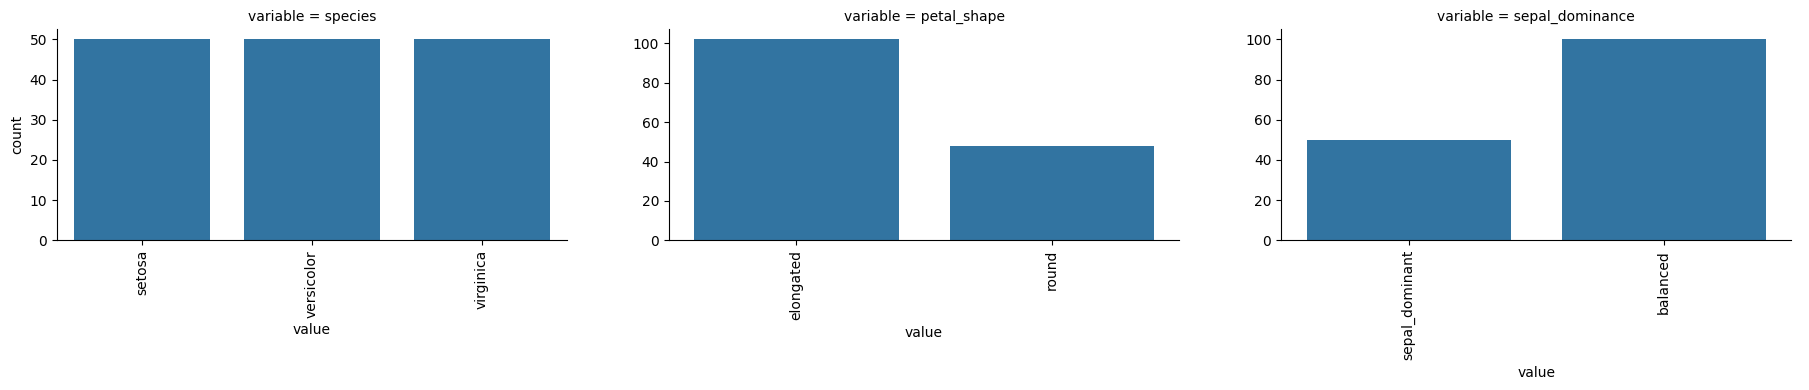

In [33]:
grid = sns.catplot(
    data=df_eda.melt(value_vars=CATEGORICAL_FEATURES),
    x="value",
    col="variable",
    col_wrap=3,
    kind="count",
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5,
)
for ax in grid.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(90)
        label.set_ha("center")
grid.figure.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

#### Count Plots with Facets - Explore Relationships Between Categorical Variables

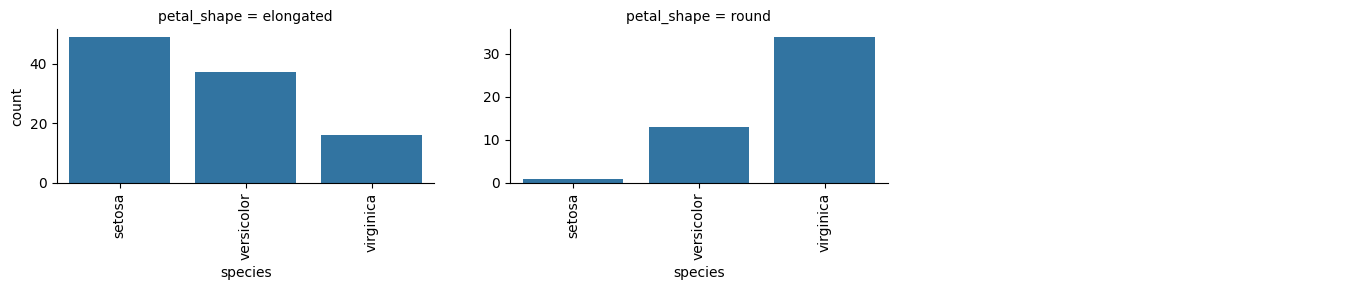

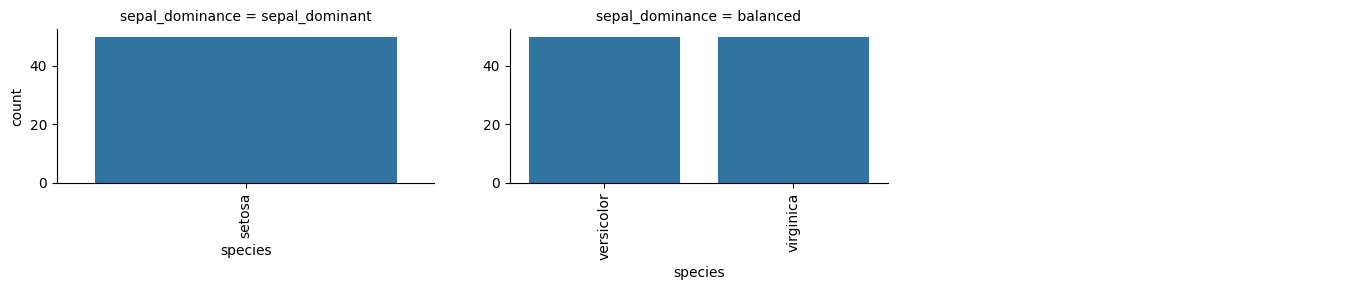

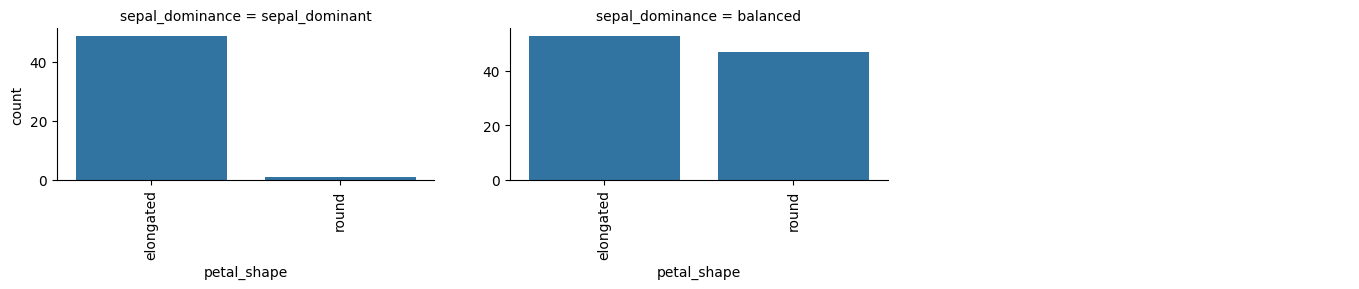

In [34]:
pairs = list(combinations(CATEGORICAL_FEATURES, 2))
for x_var, col_var in pairs:
    grid = sns.catplot(
        data=df_eda,
        x=x_var,
        col=col_var,
        col_wrap=3,
        kind="count",
        sharex=False,
        sharey=False,
        height=3,
        aspect=1.5,
    )
    for ax in grid.axes.flatten():
        for label in ax.get_xticklabels():
            label.set_rotation(90)
            label.set_ha("center")
    grid.figure.tight_layout()
    grid.figure.subplots_adjust(hspace=1.0, wspace=0.2)
    plt.show()

### Histogram Plots – Marginal Distributions of Each Numerical Variable, w/ Facets for Each Numerical Variable

In [35]:
df_eda_lf = (
    df_eda.reset_index()
    .rename(columns={"index": "rowid"})
    .melt(id_vars=["rowid"] + CATEGORICAL_FEATURES, value_vars=CONTINUOUS_FEATURES)
)
df_eda_lf

,rowid,species,petal_shape,sepal_dominance,variable,value
0,0,setosa,elongated,sepal_dominant,sepal_length,5.1
1,1,setosa,elongated,sepal_dominant,sepal_length,4.9
2,2,setosa,elongated,sepal_dominant,sepal_length,4.7
3,3,setosa,elongated,sepal_dominant,sepal_length,4.6
4,4,setosa,elongated,sepal_dominant,sepal_length,5.0
...,...,...,...,...,...,...
595,145,virginica,round,balanced,petal_width,2.3
596,146,virginica,round,balanced,petal_width,1.9
597,147,virginica,round,balanced,petal_width,2.0
598,148,virginica,round,balanced,petal_width,2.3


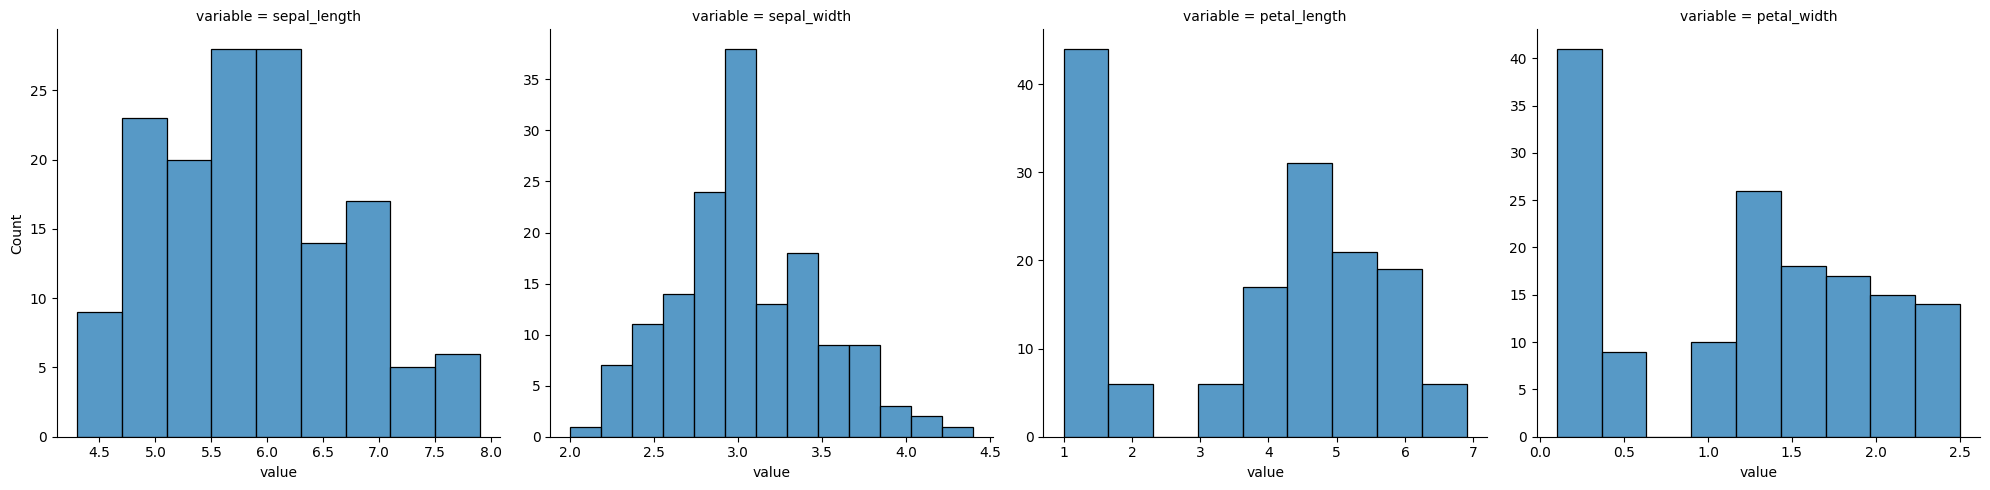

In [36]:
sns.displot(
    data=df_eda_lf,
    x="value",
    col="variable",
    col_wrap=4,
    kind="hist",
    facet_kws={"sharex": False, "sharey": False},
    common_bins=False,
)
plt.show()

### Histogram Plots with Facets - Explore Relationships Between Numerical & Categorical Variables

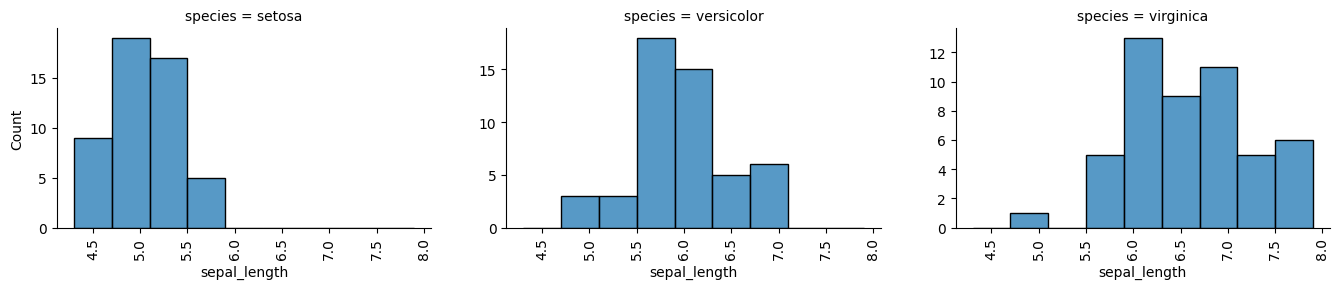

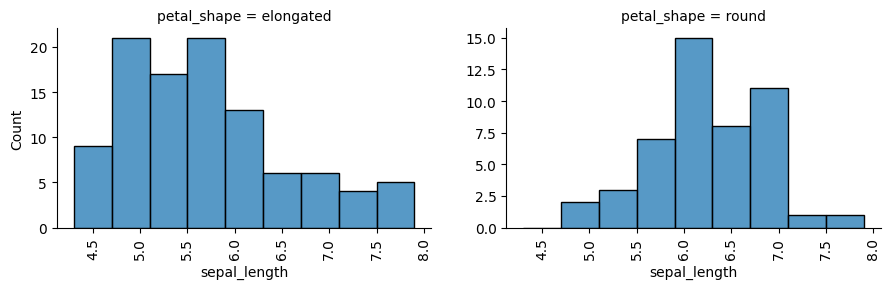

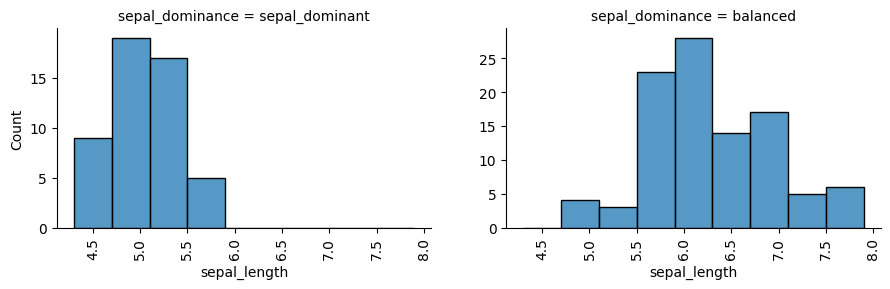

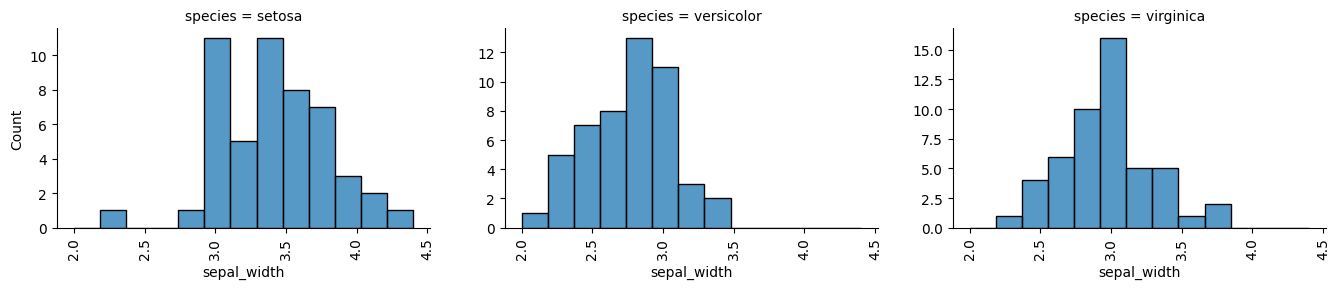

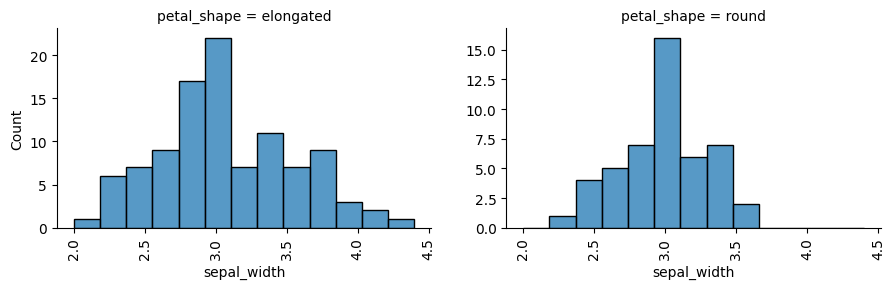

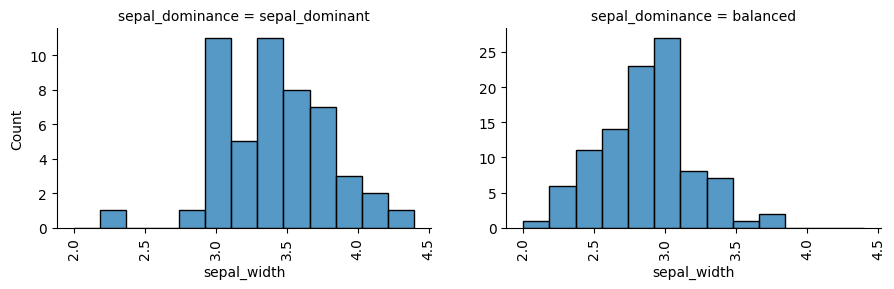

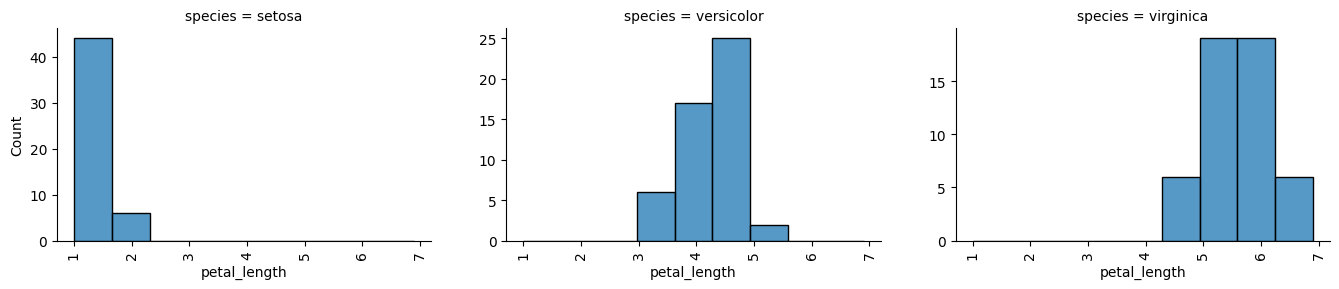

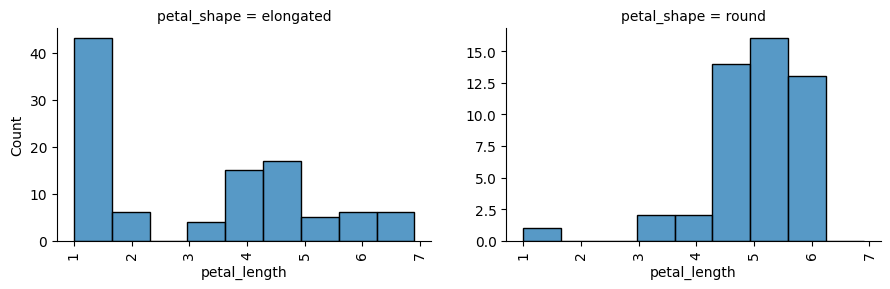

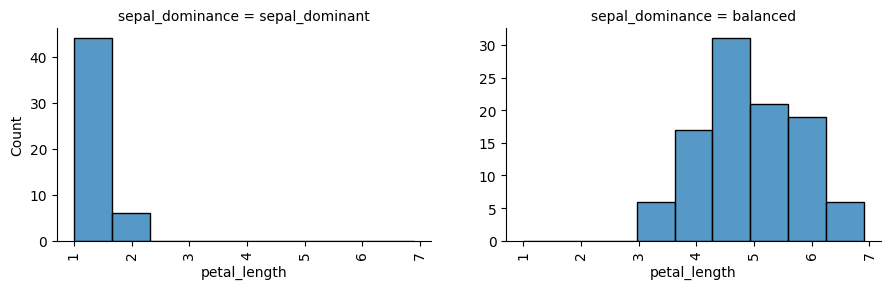

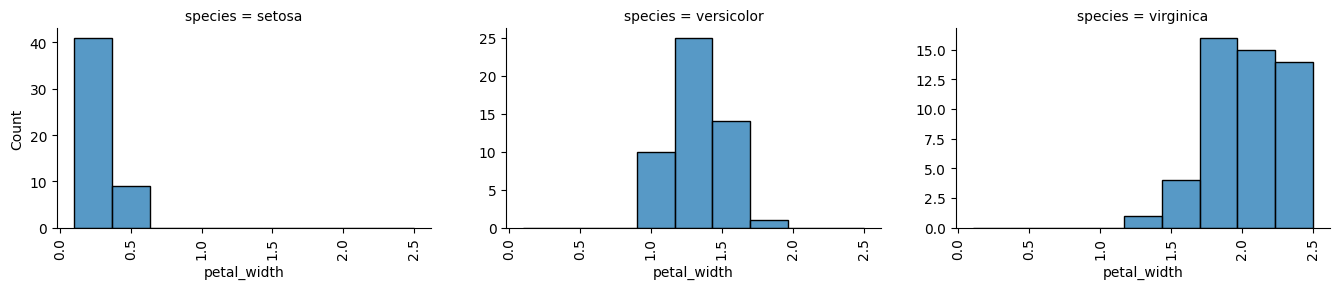

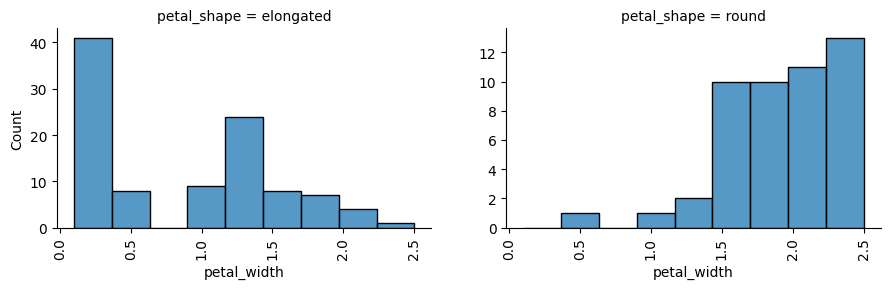

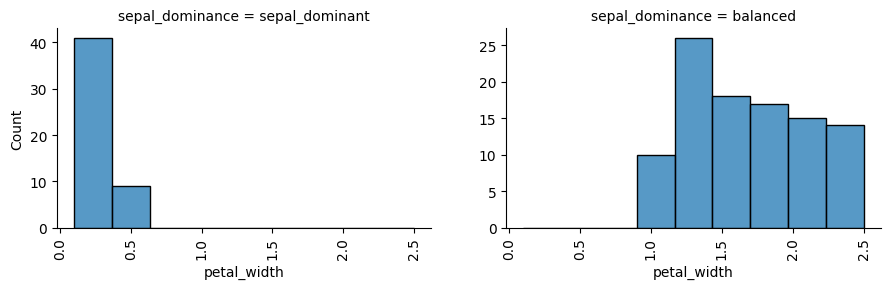

In [37]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        grid = sns.displot(
            data=df_eda,
            x=num_var,
            col=cat_var,
            col_wrap=3,
            kind="hist",
            facet_kws={"sharex": False, "sharey": False},
            height=3,
            aspect=1.5,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Box Plots – Distribution of Each Numerical Variable by Categorical Variable, Faceted by the Respective Numerical Variable

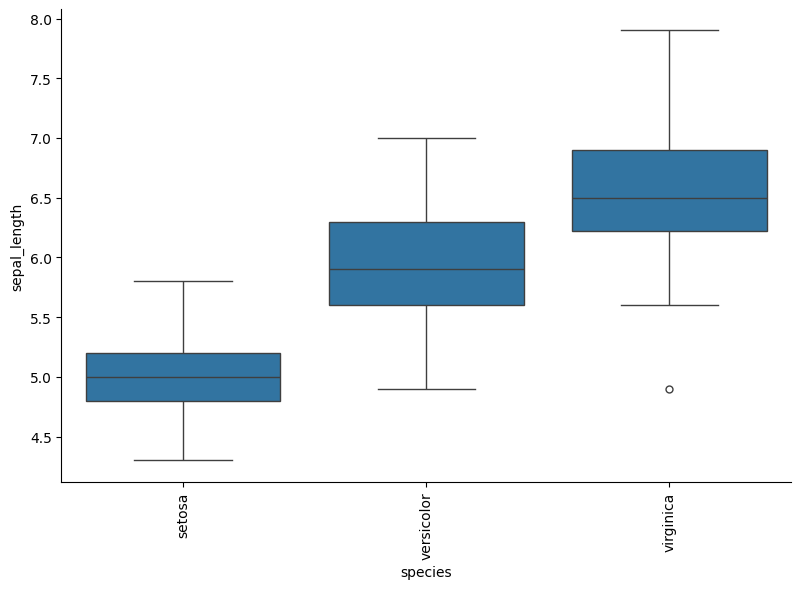

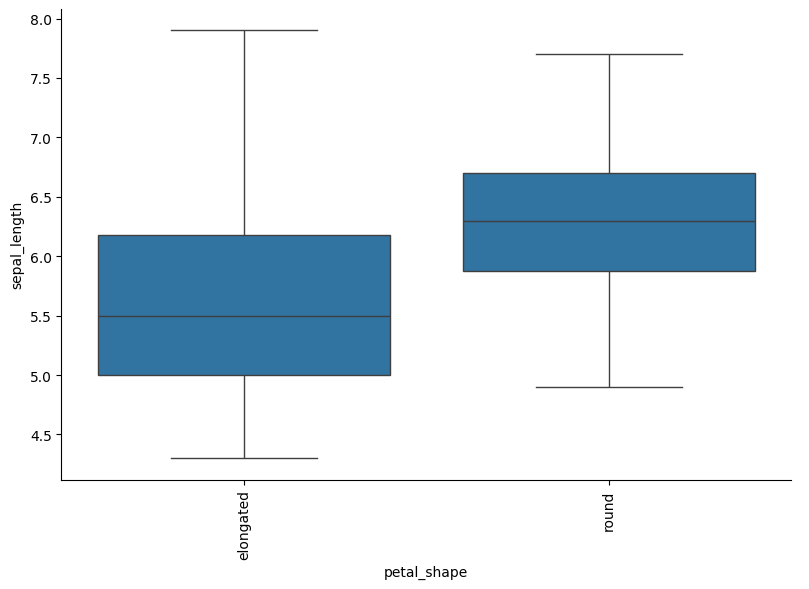

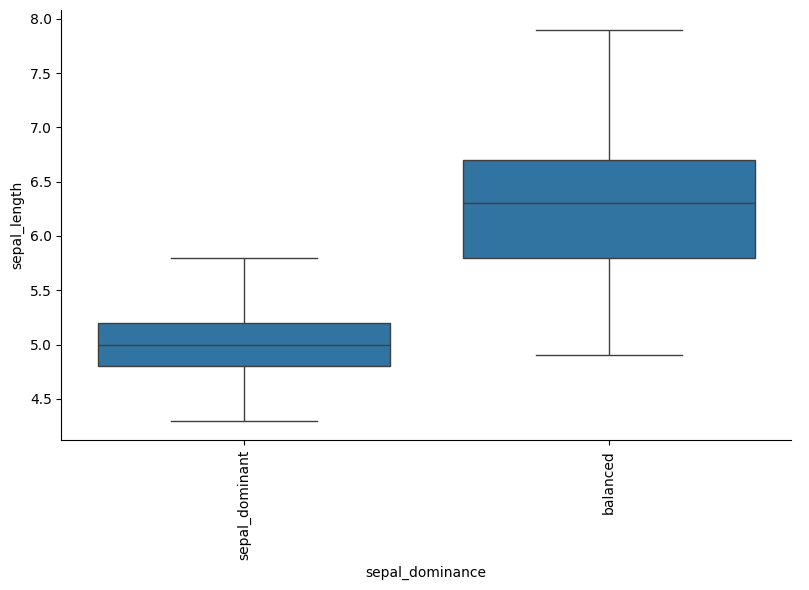

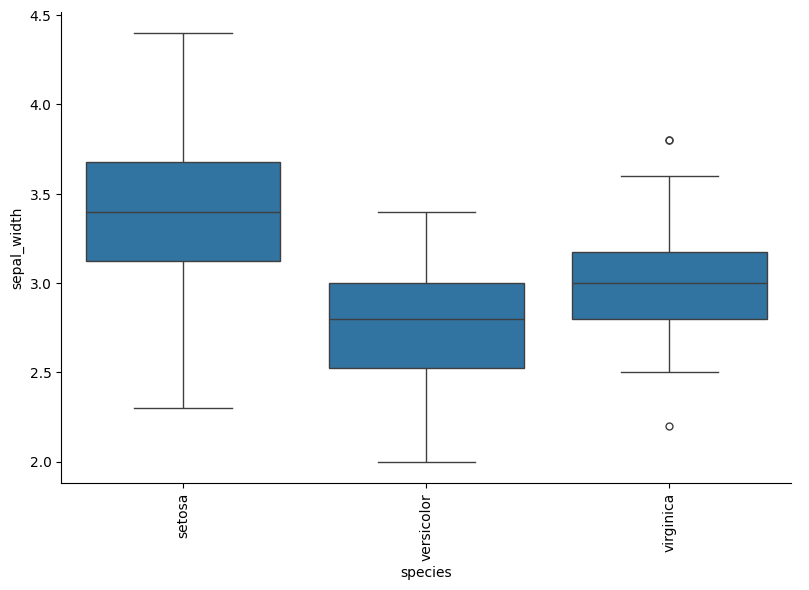

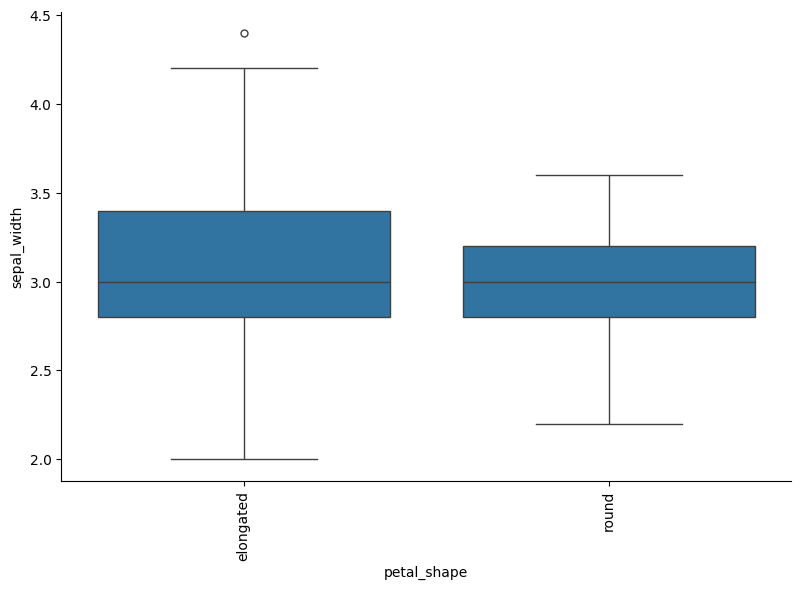

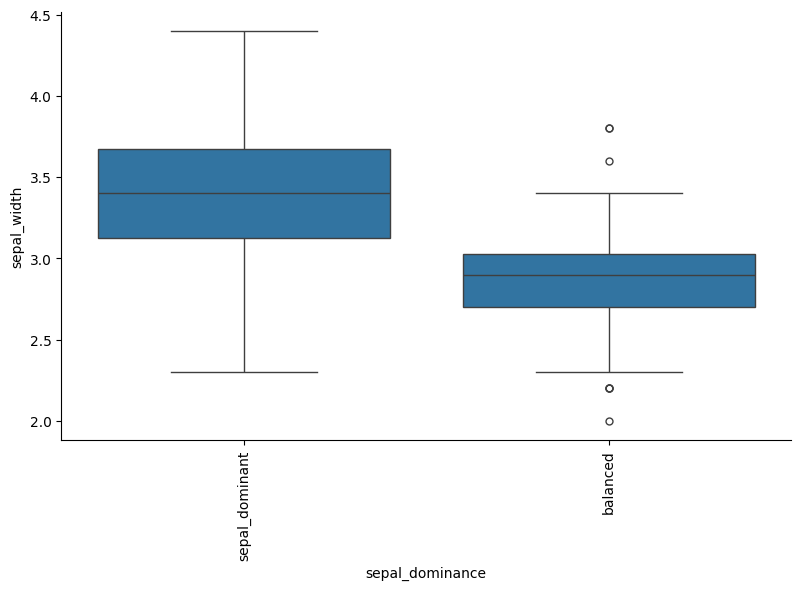

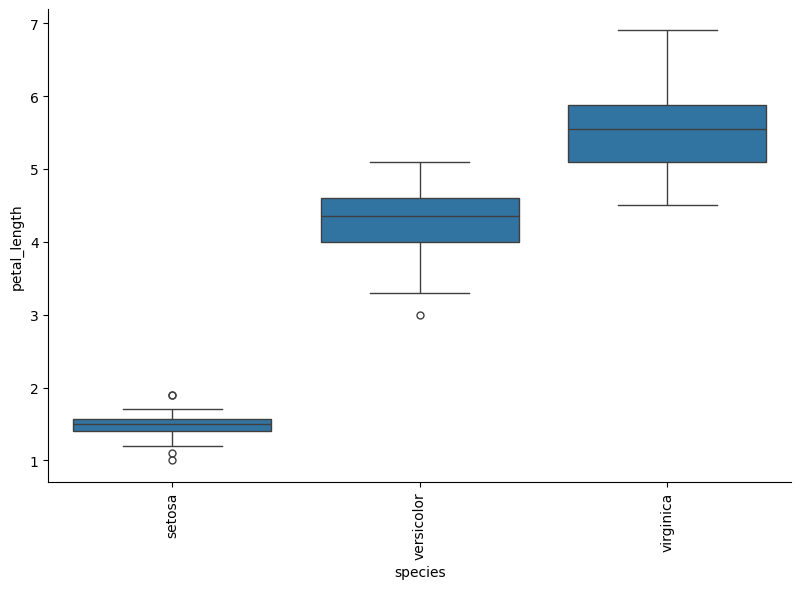

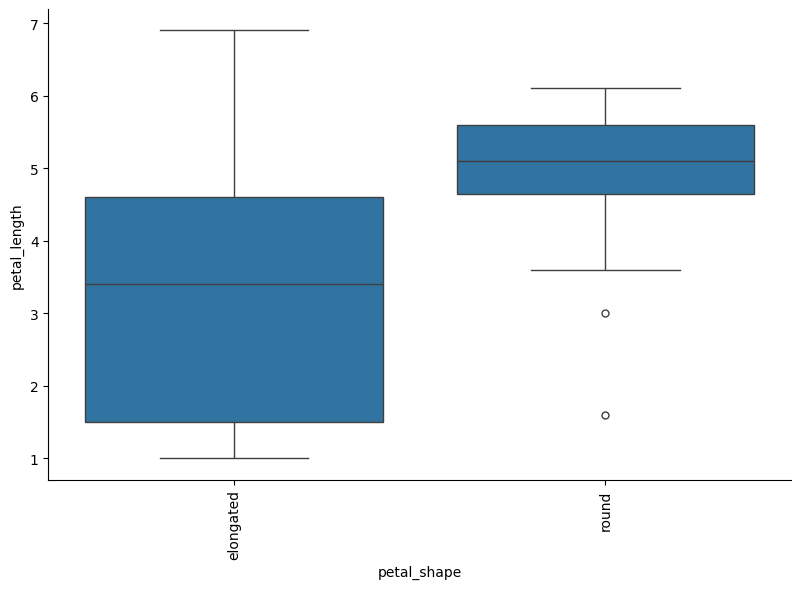

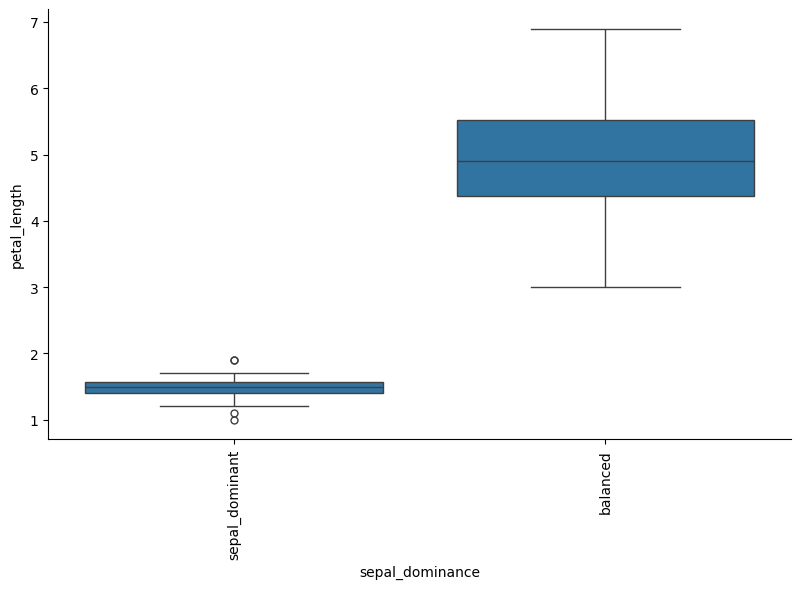

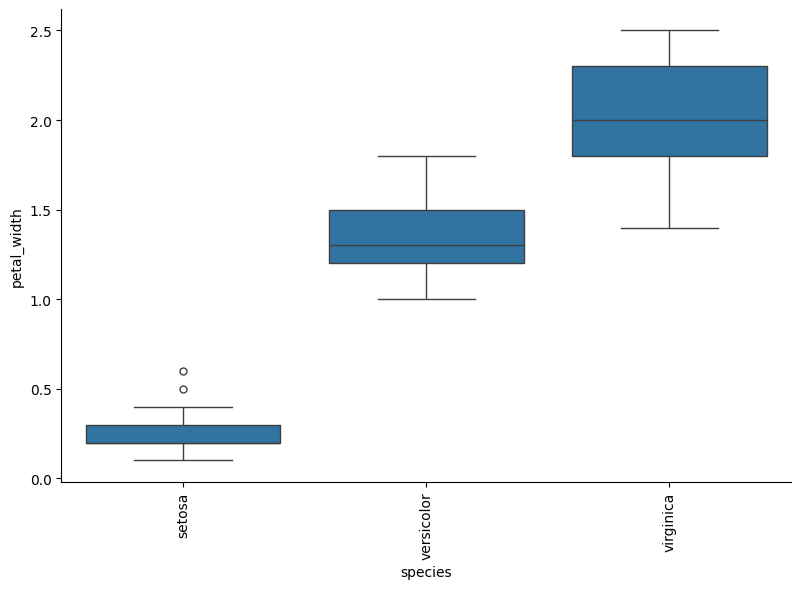

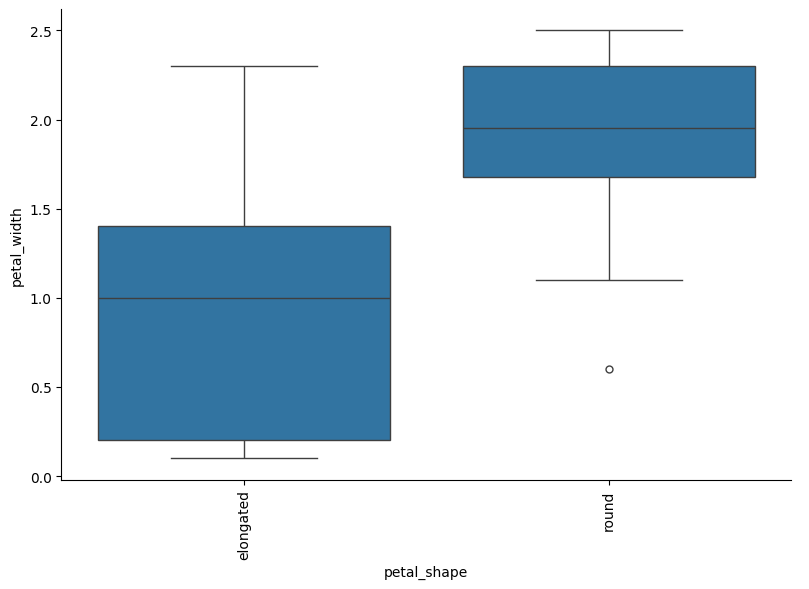

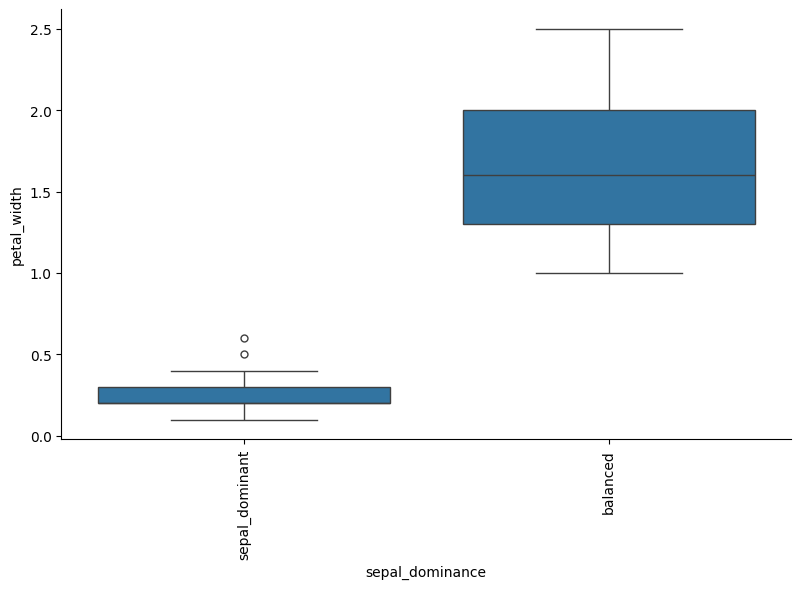

In [38]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        n_categories = df_eda[cat_var].nunique()
        fig_width = max(8, n_categories * 0.6)
        grid = sns.catplot(
            data=df_eda,
            x=cat_var,
            y=num_var,
            kind="box",
            height=6,
            aspect=fig_width / 6,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Point Plots – Mean and Confidence Interval of Each Numerical Variable by Categorical Variable, Faceted by the Respective Numerical Variable

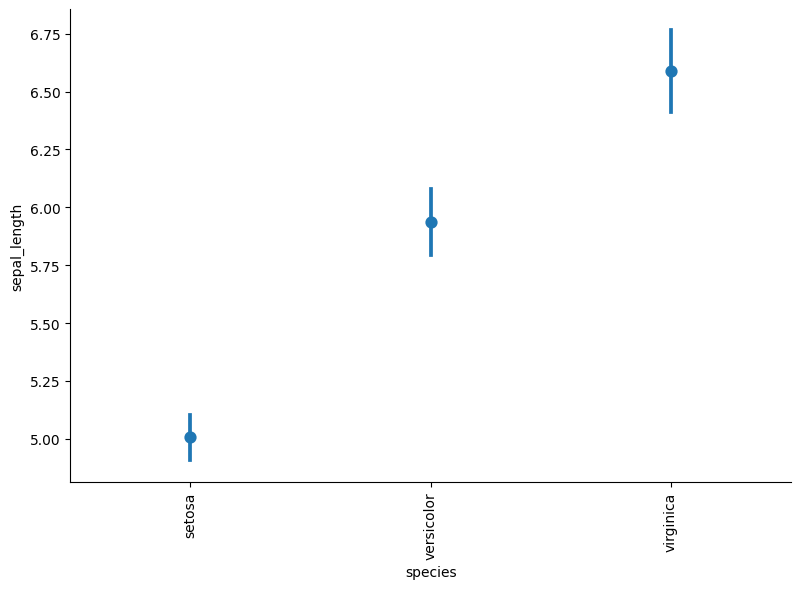

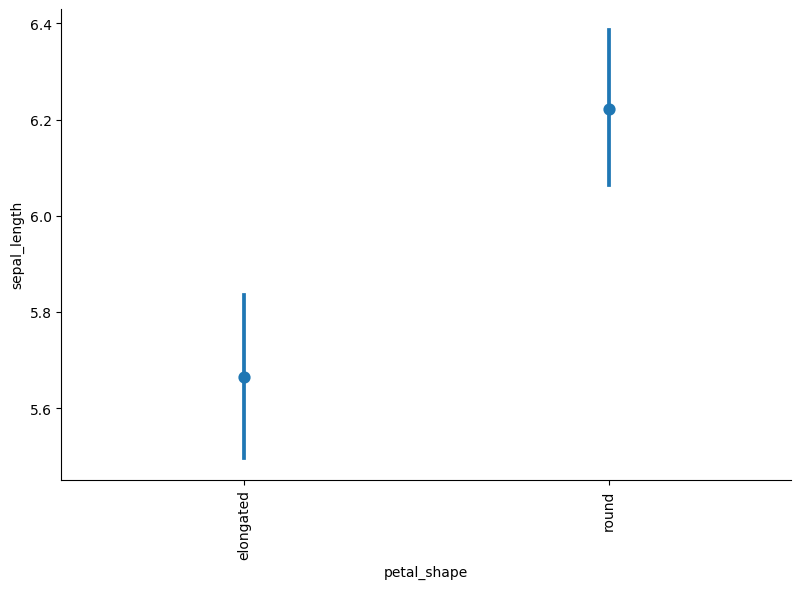

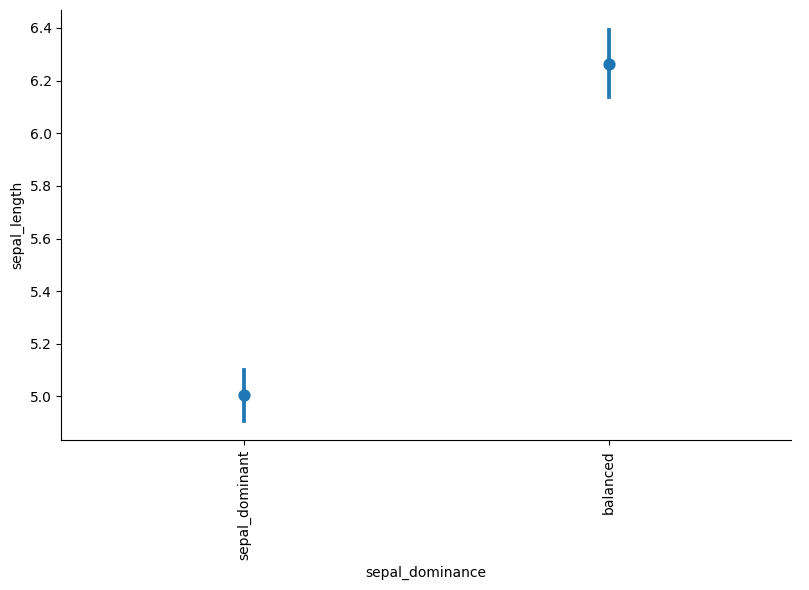

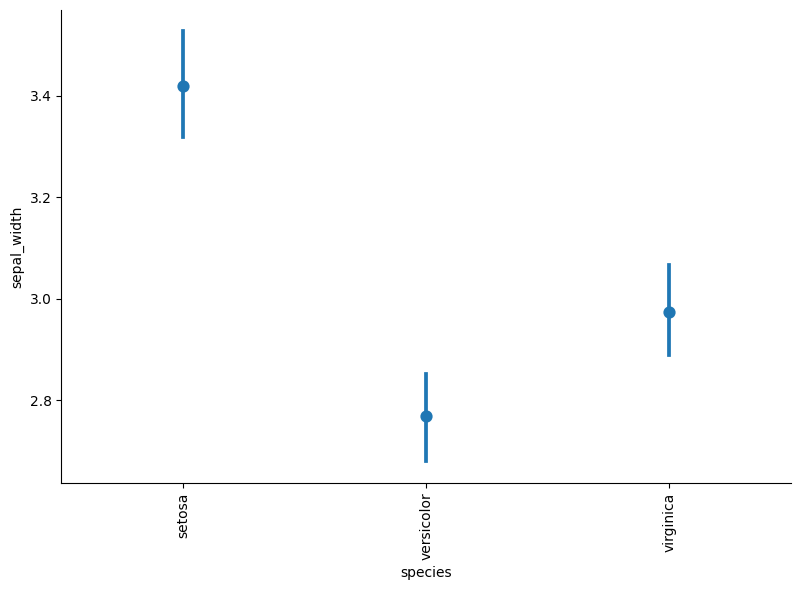

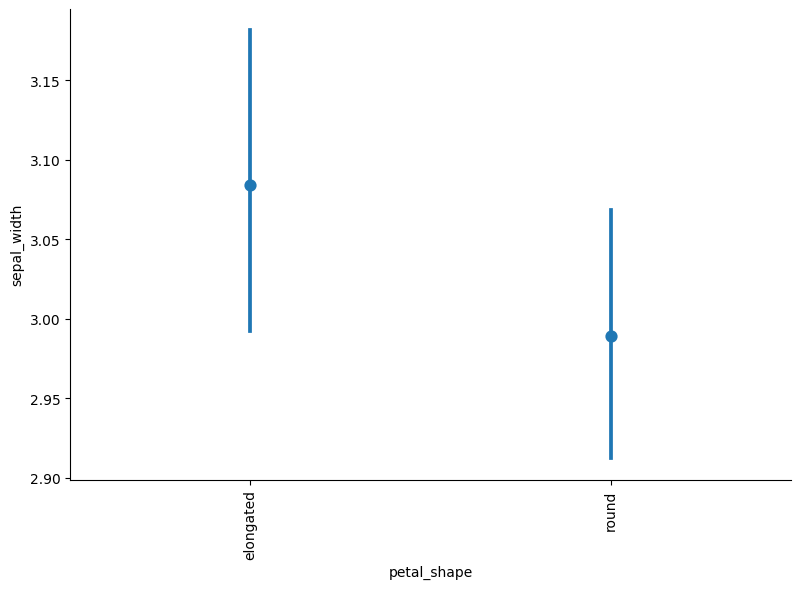

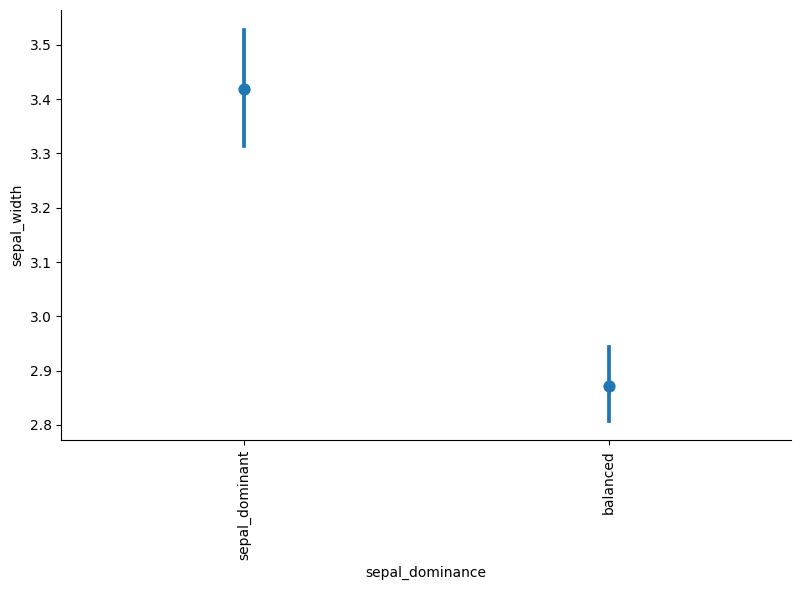

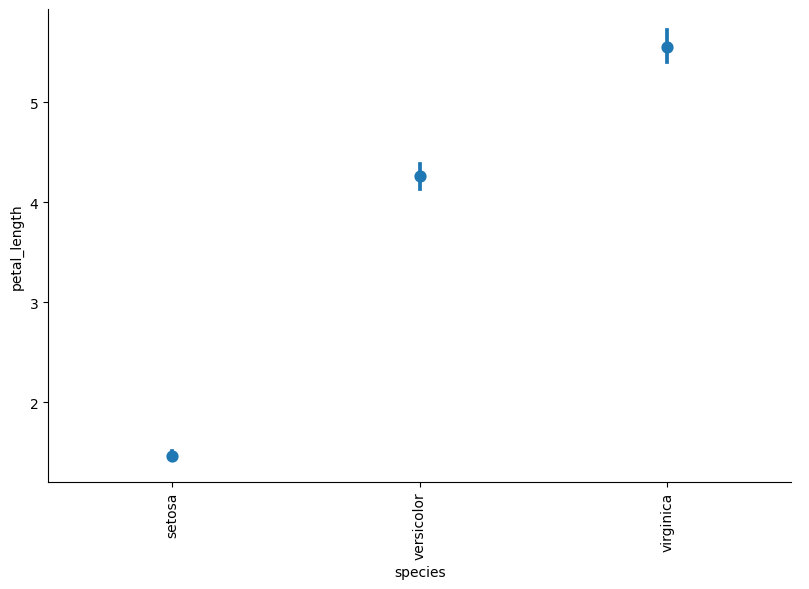

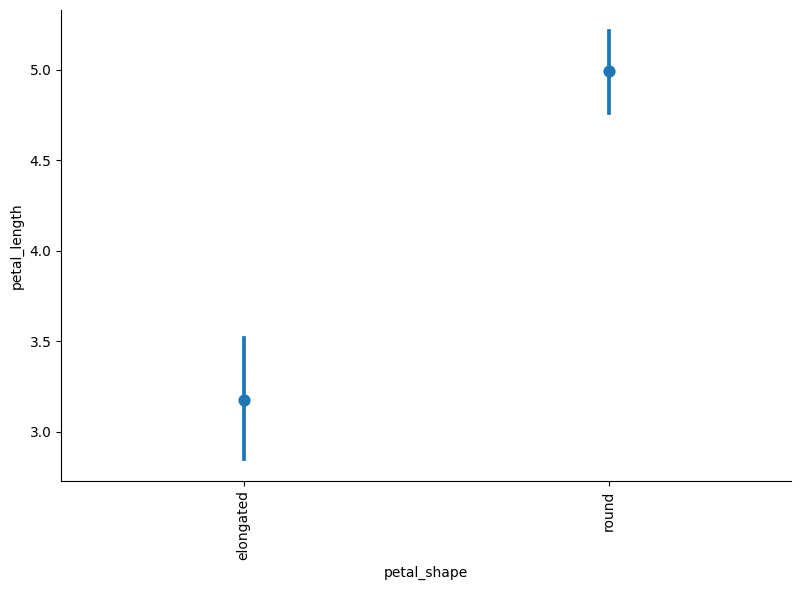

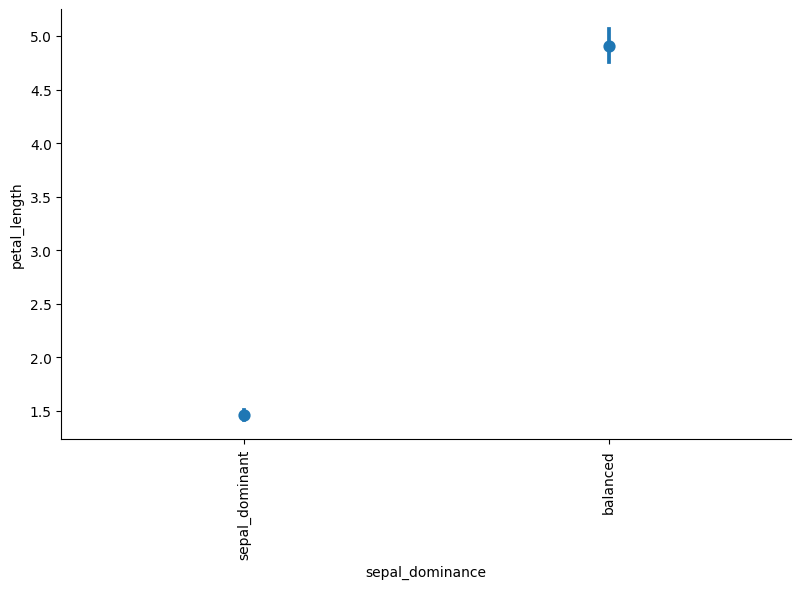

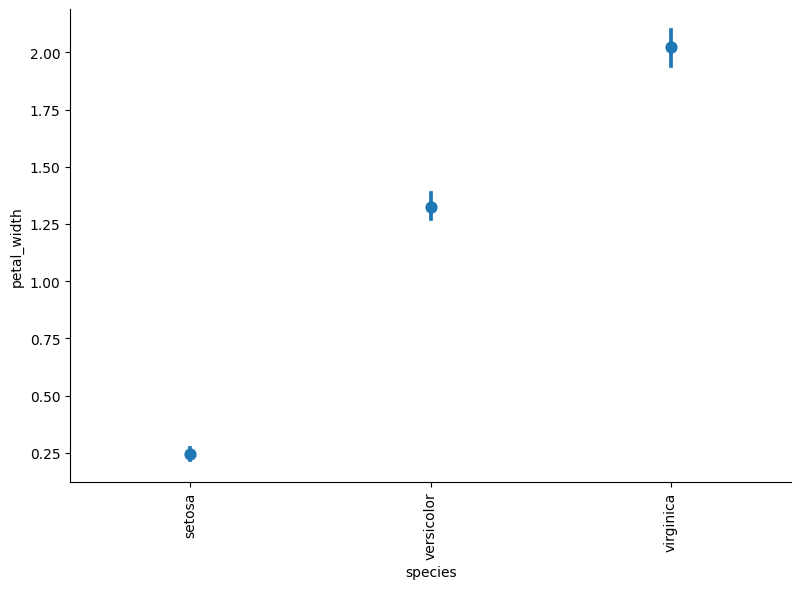

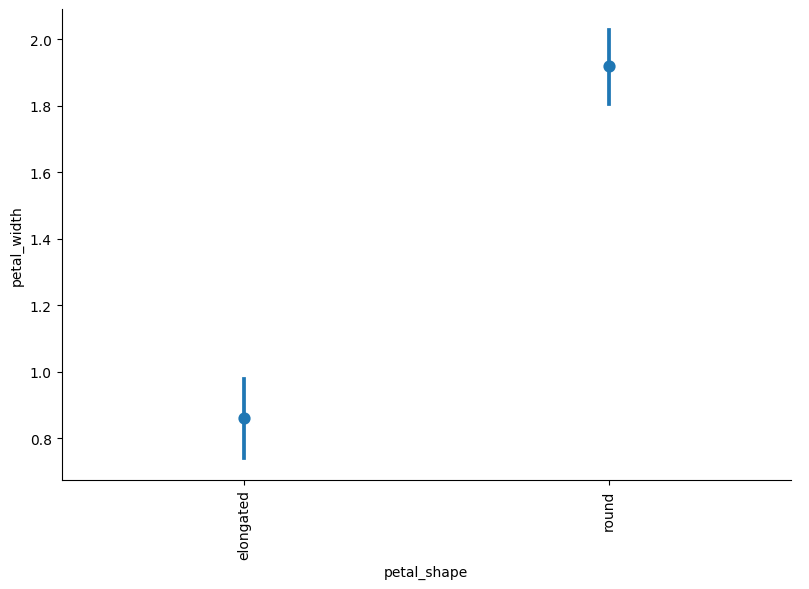

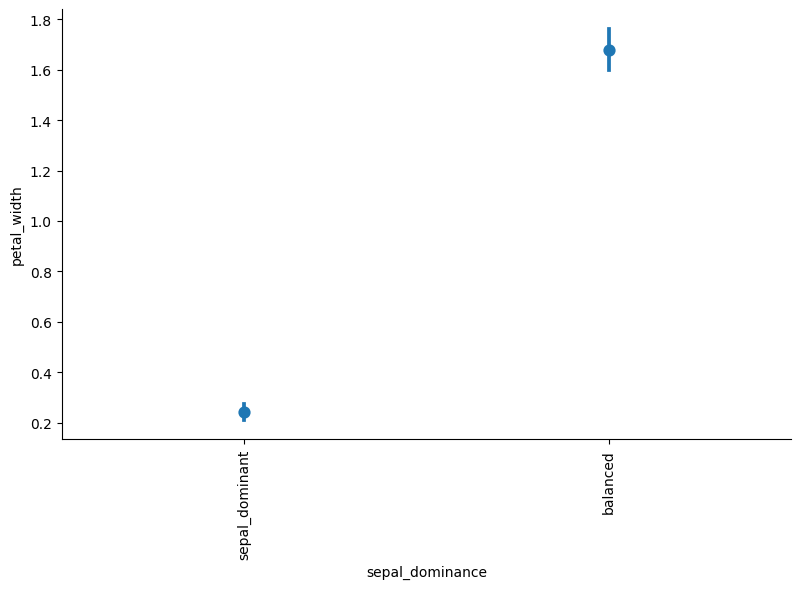

In [39]:
for num_var in CONTINUOUS_FEATURES:
    for cat_var in CATEGORICAL_FEATURES:
        n_categories = df_eda[cat_var].nunique()
        fig_width = max(8, n_categories * 0.6)
        grid = sns.catplot(
            data=df_eda,
            x=cat_var,
            y=num_var,
            kind="point",
            linestyle="none",
            height=6,
            aspect=fig_width / 6,
        )
        for ax in grid.axes.flatten():
            for label in ax.get_xticklabels():
                label.set_rotation(90)
                label.set_ha("center")
        grid.figure.tight_layout()
        grid.figure.subplots_adjust(hspace=0.4, wspace=0.2)
        plt.show()

### Encode Categorical Variables for Correlation, Feature Importance Analysis & Modeling

In [40]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species             object
petal_shape         object
sepal_dominance     object
dtype: object

#### Encode `species` as Integer Labels (Classification)

In [41]:
df_eda["species"]

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

In [42]:
df_eda["species"].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

In [43]:
df_eda["species"] = df_eda["species"].map(
    {
        "setosa": 0,
        "versicolor": 1,
        "virginica": 2,
    }
)
df_eda["species"]

0      0
1      0
2      0
3      0
4      0
      ..
145    2
146    2
147    2
148    2
149    2
Name: species, Length: 150, dtype: int64

#### Encode `petal_shape` as Binary Float

In [44]:
df_eda["petal_shape"]

0      elongated
1      elongated
2      elongated
3      elongated
4      elongated
         ...    
145        round
146        round
147        round
148        round
149        round
Name: petal_shape, Length: 150, dtype: object

In [45]:
df_eda["petal_shape"].value_counts()

petal_shape
elongated    102
round         48
Name: count, dtype: int64

In [46]:
df_eda["petal_shape"] = (
    df_eda["petal_shape"].map({"round": 0, "elongated": 1}).astype(float)
)
df_eda["petal_shape"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: petal_shape, Length: 150, dtype: float64

#### Encode `sepal_dominance` as Binary Float

In [47]:
df_eda["sepal_dominance"]

0      sepal_dominant
1      sepal_dominant
2      sepal_dominant
3      sepal_dominant
4      sepal_dominant
            ...      
145          balanced
146          balanced
147          balanced
148          balanced
149          balanced
Name: sepal_dominance, Length: 150, dtype: object

In [48]:
df_eda["sepal_dominance"].value_counts()

sepal_dominance
balanced          100
sepal_dominant     50
Name: count, dtype: int64

In [49]:
df_eda["sepal_dominance"] = (
    df_eda["sepal_dominance"].map({"balanced": 0, "sepal_dominant": 1}).astype(float)
)
df_eda["sepal_dominance"]

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
145    0.0
146    0.0
147    0.0
148    0.0
149    0.0
Name: sepal_dominance, Length: 150, dtype: float64

### Verify Data Types Match PyTorch Requirements (float for `X`, int for `y`)

In [50]:
df_eda.dtypes

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
species              int64
petal_shape        float64
sepal_dominance    float64
dtype: object

### Correlation Plots – Correlation Matrix of All Numerical Variables

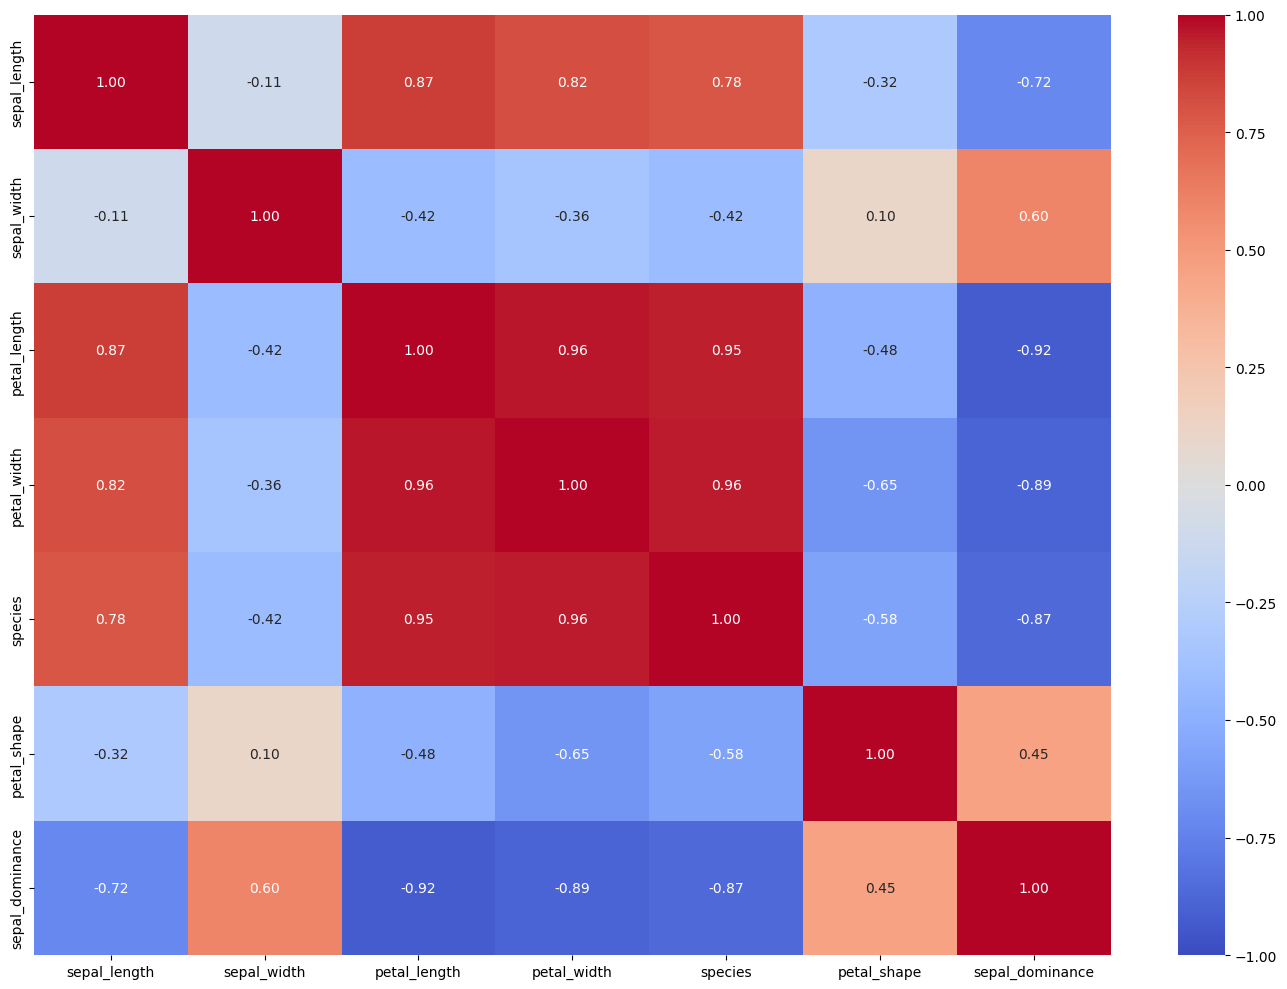

In [51]:
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(
    data=df_eda.corr(),
    vmin=-1,
    vmax=1,
    center=0,
    cmap="coolwarm",
    cbar=True,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 10},
    ax=ax,
)
plt.tight_layout()
plt.show()

### Correlation Plots – Feature Correlation w/ Target Variable (`species`)

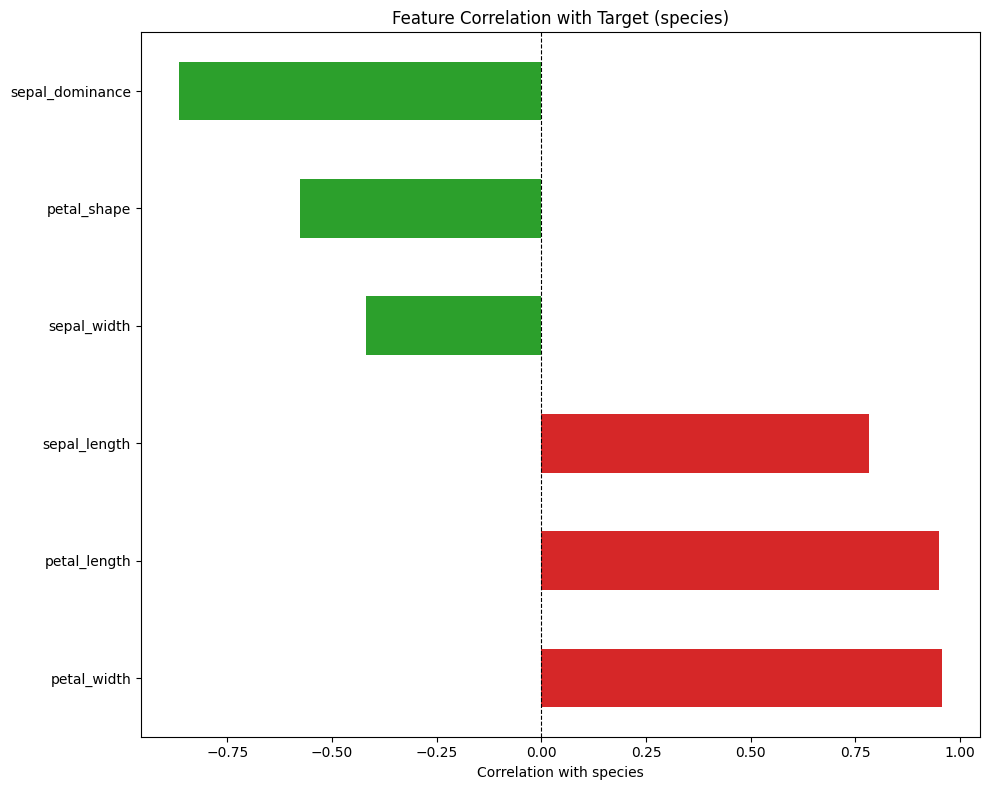

In [52]:
feature_vars = df_eda.columns.drop(TARGET_VAR)
corr_with_target = (
    df_eda[feature_vars].corrwith(df_eda[TARGET_VAR]).sort_values(ascending=False)
)
fig, ax = plt.subplots(figsize=(10, 8))
colors = ["tab:red" if x >= 0 else "tab:green" for x in corr_with_target]
corr_with_target.plot(kind="barh", ax=ax, color=colors)
ax.set_xlabel(f"Correlation with {TARGET_VAR}")
ax.set_title(f"Feature Correlation with Target ({TARGET_VAR})")
ax.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.tight_layout()
plt.show()

### Create `Features` Variable for Audit & Modeling 

In [53]:
features = [col for col in df_eda.columns if col not in [TARGET_VAR]]
features

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'petal_shape',
 'sepal_dominance']

### Feature Selection Audit: Signal Strength & Cardinality

In [54]:
features = [col for col in df_eda.columns if col != TARGET_VAR]
results = []
all_corrs = df_eda[features].corrwith(df_eda[TARGET_VAR])
for col in features:
    n_unique = df_eda[col].nunique()
    corr = all_corrs[col]
    abs_corr = abs(corr)
    # Default logic
    recommendation = "❌ DROP"
    reason = f"(Weak Signal: {corr:.4f})"
    # Threshold Logic
    if abs_corr >= 0.01:
        recommendation = "✅ KEEP"
        reason = f"(Strong Signal)"
    results.append(
        {
            "Feature": col,
            "Unique_Values": n_unique,
            "Correlation": corr,
            "Recommendation": recommendation,
            "Reason": reason,
        }
    )
audit_df = pd.DataFrame(results)
# Create a temporary column for absolute sorting
audit_df["abs_corr"] = audit_df["Correlation"].abs()
# Sort by absolute correlation, Drop the temp column, and RESET the index
audit_df = (
    audit_df.sort_values("abs_corr", ascending=False)
    .drop(columns=["abs_corr"])
    .reset_index(drop=True)
)
audit_df

,Feature,Unique_Values,Correlation,Recommendation,Reason
0,petal_width,22,0.956464,✅ KEEP,(Strong Signal)
1,petal_length,43,0.949043,✅ KEEP,(Strong Signal)
2,sepal_dominance,2,-0.866025,✅ KEEP,(Strong Signal)
3,sepal_length,35,0.782561,✅ KEEP,(Strong Signal)
4,petal_shape,2,-0.577616,✅ KEEP,(Strong Signal)
5,sepal_width,23,-0.419446,✅ KEEP,(Strong Signal)


## Preprocessing

### Create `df_preprocessed` Dataset

In [55]:
df_preprocessed = df_eda.copy()
df_preprocessed.shape

(150, 7)

### Drop Low-Correlation Features

#### Based on EDA Recommendations, Drop Features w/ Correlation < 0.01; Low-Correlation

In [56]:
# df_preprocessed.drop(columns=[
#     "",
# ], inplace=True)
# df_preprocessed

### Save `df_preprocess` Processed Dataset

In [57]:
df_preprocessed.to_csv("iris_dataset_preprocessed.csv", index=False)

### Load `df_preprocess` Processed Dataset

In [58]:
df_preprocessed = pd.read_csv("iris_dataset_preprocessed.csv")
df_preprocessed

,sepal_length,sepal_width,petal_length,petal_width,species,petal_shape,sepal_dominance
0,5.1,3.5,1.4,0.2,0,1.0,1.0
1,4.9,3.0,1.4,0.2,0,1.0,1.0
2,4.7,3.2,1.3,0.2,0,1.0,1.0
3,4.6,3.1,1.5,0.2,0,1.0,1.0
4,5.0,3.6,1.4,0.2,0,1.0,1.0
...,...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,0.0,0.0
146,6.3,2.5,5.0,1.9,2,0.0,0.0
147,6.5,3.0,5.2,2.0,2,0.0,0.0
148,6.2,3.4,5.4,2.3,2,0.0,0.0


## Model

In [59]:
class Model(nn.Module):
    """
    A feedforward neural network with two hidden layers and optional dropout.
    """

    def __init__(
        self,
        in_features=IN_FEATURES,
        h1=H1,
        h2=H2,
        out_features=OUT_FEATURES,
        dropout=DROPOUT,
    ):
        """
        Initializes the neural network layers.

        Parameters:
            in_features (int): Number of input features.
            h1 (int): Number of neurons in the first hidden layer.
            h2 (int): Number of neurons in the second hidden layer.
            out_features (int): Number of output features.
            dropout (float): Dropout rate (0.0 = no dropout).

        Returns:
            None
        """
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

### Instantiate Model

In [60]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
model = Model().to(DEVICE)
model

Model(
  (fc1): Linear(in_features=6, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [61]:
next(model.parameters()).device

device(type='mps', index=0)

### Train-Test Split Model

In [62]:
X = df_preprocessed.drop(TARGET_VAR, axis=1).values.astype("float32")
X

array([[5.1, 3.5, 1.4, 0.2, 1. , 1. ],
       [4.9, 3. , 1.4, 0.2, 1. , 1. ],
       [4.7, 3.2, 1.3, 0.2, 1. , 1. ],
       [4.6, 3.1, 1.5, 0.2, 1. , 1. ],
       [5. , 3.6, 1.4, 0.2, 1. , 1. ],
       [5.4, 3.9, 1.7, 0.4, 1. , 1. ],
       [4.6, 3.4, 1.4, 0.3, 1. , 1. ],
       [5. , 3.4, 1.5, 0.2, 1. , 1. ],
       [4.4, 2.9, 1.4, 0.2, 1. , 1. ],
       [4.9, 3.1, 1.5, 0.1, 1. , 1. ],
       [5.4, 3.7, 1.5, 0.2, 1. , 1. ],
       [4.8, 3.4, 1.6, 0.2, 1. , 1. ],
       [4.8, 3. , 1.4, 0.1, 1. , 1. ],
       [4.3, 3. , 1.1, 0.1, 1. , 1. ],
       [5.8, 4. , 1.2, 0.2, 1. , 1. ],
       [5.7, 4.4, 1.5, 0.4, 1. , 1. ],
       [5.4, 3.9, 1.3, 0.4, 1. , 1. ],
       [5.1, 3.5, 1.4, 0.3, 1. , 1. ],
       [5.7, 3.8, 1.7, 0.3, 1. , 1. ],
       [5.1, 3.8, 1.5, 0.3, 1. , 1. ],
       [5.4, 3.4, 1.7, 0.2, 1. , 1. ],
       [5.1, 3.7, 1.5, 0.4, 1. , 1. ],
       [4.6, 3.6, 1. , 0.2, 1. , 1. ],
       [5.1, 3.3, 1.7, 0.5, 1. , 1. ],
       [4.8, 3.4, 1.9, 0.2, 1. , 1. ],
       [5. , 3. , 1.6, 0.

In [63]:
X.shape

(150, 6)

In [64]:
y = df_preprocessed[TARGET_VAR].values.astype("int64")
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [65]:
y.shape

(150,)

In [66]:
train_idx, test_idx = train_test_split(
    np.arange(len(X)), test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
len(train_idx), len(test_idx)

(105, 45)

In [67]:
X_train

array([[5.1, 2.5, 3. , 1.1, 0. , 0. ],
       [6.2, 2.2, 4.5, 1.5, 0. , 0. ],
       [5.1, 3.8, 1.5, 0.3, 1. , 1. ],
       [6.8, 3.2, 5.9, 2.3, 0. , 0. ],
       [5.7, 2.8, 4.1, 1.3, 1. , 0. ],
       [6.7, 3. , 5.2, 2.3, 0. , 0. ],
       [4.9, 3.1, 1.5, 0.1, 1. , 1. ],
       [5.1, 3.8, 1.6, 0.2, 1. , 1. ],
       [4.4, 2.9, 1.4, 0.2, 1. , 1. ],
       [7.1, 3. , 5.9, 2.1, 0. , 0. ],
       [6.5, 3.2, 5.1, 2. , 0. , 0. ],
       [4.9, 3. , 1.4, 0.2, 1. , 1. ],
       [5. , 3. , 1.6, 0.2, 1. , 1. ],
       [6. , 2.9, 4.5, 1.5, 0. , 0. ],
       [5.5, 2.4, 3.8, 1.1, 1. , 0. ],
       [7.2, 3.2, 6. , 1.8, 1. , 0. ],
       [5. , 3.4, 1.6, 0.4, 1. , 1. ],
       [4.7, 3.2, 1.6, 0.2, 1. , 1. ],
       [6.7, 3.3, 5.7, 2.5, 0. , 0. ],
       [5.9, 3.2, 4.8, 1.8, 0. , 0. ],
       [5.4, 3.4, 1.5, 0.4, 1. , 1. ],
       [6.3, 2.7, 4.9, 1.8, 0. , 0. ],
       [7.6, 3. , 6.6, 2.1, 1. , 0. ],
       [7.7, 2.8, 6.7, 2. , 1. , 0. ],
       [5.7, 3. , 4.2, 1.2, 1. , 0. ],
       [4.6, 3.4, 1.4, 0.

In [68]:
X_train.shape

(105, 6)

In [69]:
y_train

array([1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 2,
       2, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0,
       2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0])

In [70]:
y_train.shape

(105,)

In [71]:
X_test

array([[7.3, 2.9, 6.3, 1.8, 1. , 0. ],
       [6.1, 2.9, 4.7, 1.4, 1. , 0. ],
       [6.3, 2.8, 5.1, 1.5, 1. , 0. ],
       [6.3, 3.3, 4.7, 1.6, 0. , 0. ],
       [6.1, 3. , 4.9, 1.8, 0. , 0. ],
       [6.7, 3.1, 5.6, 2.4, 0. , 0. ],
       [5.5, 2.3, 4. , 1.3, 1. , 0. ],
       [5.6, 2.5, 3.9, 1.1, 1. , 0. ],
       [5.4, 3.4, 1.7, 0.2, 1. , 1. ],
       [6.9, 3.1, 5.1, 2.3, 0. , 0. ],
       [5.8, 4. , 1.2, 0.2, 1. , 1. ],
       [4.4, 3. , 1.3, 0.2, 1. , 1. ],
       [6.7, 2.5, 5.8, 1.8, 1. , 0. ],
       [6.5, 3. , 5.5, 1.8, 1. , 0. ],
       [5.2, 3.4, 1.4, 0.2, 1. , 1. ],
       [6.2, 3.4, 5.4, 2.3, 0. , 0. ],
       [4.9, 2.4, 3.3, 1. , 1. , 0. ],
       [5.4, 3.7, 1.5, 0.2, 1. , 1. ],
       [5.1, 3.3, 1.7, 0.5, 1. , 1. ],
       [5.7, 3.8, 1.7, 0.3, 1. , 1. ],
       [6.2, 2.9, 4.3, 1.3, 1. , 0. ],
       [5. , 3.4, 1.5, 0.2, 1. , 1. ],
       [6.6, 3. , 4.4, 1.4, 1. , 0. ],
       [6.5, 3. , 5.8, 2.2, 0. , 0. ],
       [6. , 3. , 4.8, 1.8, 0. , 0. ],
       [6.4, 3.2, 4.5, 1.

In [72]:
X_test.shape

(45, 6)

In [73]:
y_test

array([2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2,
       1])

In [74]:
y_test.shape

(45,)

### Scale Features

In [75]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

# Save scaler for inference
joblib.dump(scaler, "iris_scaler.pkl")
print("Scaler Saved: 'iris_scaler.pkl'")

Scaler Saved: 'iris_scaler.pkl'


### Create Custom Dataset (Memory Efficient)

In [76]:
class NumpyDataset(torch.utils.data.Dataset):
    """
    A memory-efficient dataset that keeps data as numpy arrays.
    Converts to tensors only when batching (on-demand).
    Specifically designed for classification tasks.
    """

    def __init__(self, X, y, device):
        """
        Initializes the dataset with numpy arrays.

        Parameters:
            X (np.ndarray): Feature array.
            y (np.ndarray): Label array (classification targets).
            device (torch.device): Device to move tensors to.

        Returns:
            None
        """
        self.X = X
        self.y = y
        self.device = device

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns a single sample as tensors on the specified device.

        Parameters:
            idx (int): Index of the sample.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Feature and label tensors.
        """
        X_tensor = torch.tensor(self.X[idx]).float().to(self.device)
        y_tensor = torch.tensor(self.y[idx]).long().to(self.device)
        return X_tensor, y_tensor

## Create DataLoaders

In [77]:
train_dataset = NumpyDataset(X_train_scaled.values, y_train, DEVICE)
test_dataset = NumpyDataset(X_test_scaled.values, y_test, DEVICE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_loader), len(test_loader)

(4, 2)

## Create Loss Function & Optimizer

In [78]:
# Initialize the model strictly using CrossEntropyLoss for the classification task
if df[TARGET_VAR].nunique() == 2:
    # Binary Classification (Output layer must have 1 neuron)
    criterion = nn.BCEWithLogitsLoss()
else:
    # Multi-class Classification (Output layer must have 2+ neurons)
    criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [79]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)

## Train Model

In [80]:
train_losses = []
val_losses = []
train_losses, val_losses

([], [])

In [81]:
best_val_loss = float("inf")
for i in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_val_pred = model(X_batch)
            epoch_val_loss += criterion(y_val_pred, y_batch).item()
    val_loss = epoch_val_loss / len(test_loader)
    val_losses.append(val_loss)
    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "iris_model.pth")
    if i % LOG_INTERVAL == 0:
        print(
            f"Epoch {i}/{EPOCHS} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}"
        )
print("-" * 30)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("Model Weights Saved: 'iris_model.pth'")

Epoch 0/1000 - Training Loss: 1.1365 - Validation Loss: 1.1353
Epoch 10/1000 - Training Loss: 0.4889 - Validation Loss: 0.4439
Epoch 20/1000 - Training Loss: 0.2784 - Validation Loss: 0.3909
Epoch 30/1000 - Training Loss: 0.1604 - Validation Loss: 0.3489
Epoch 40/1000 - Training Loss: 0.0784 - Validation Loss: 0.2354
Epoch 50/1000 - Training Loss: 0.0553 - Validation Loss: 0.1771
Epoch 60/1000 - Training Loss: 0.0396 - Validation Loss: 0.1368
Epoch 70/1000 - Training Loss: 0.0319 - Validation Loss: 0.1300
Epoch 80/1000 - Training Loss: 0.0292 - Validation Loss: 0.1357
Epoch 90/1000 - Training Loss: 0.0258 - Validation Loss: 0.1336
Epoch 100/1000 - Training Loss: 0.0226 - Validation Loss: 0.1455
Epoch 110/1000 - Training Loss: 0.0200 - Validation Loss: 0.1633
Epoch 120/1000 - Training Loss: 0.0183 - Validation Loss: 0.1561
Epoch 130/1000 - Training Loss: 0.0263 - Validation Loss: 0.1887
Epoch 140/1000 - Training Loss: 0.0188 - Validation Loss: 0.1594
Epoch 150/1000 - Training Loss: 0.01

## Evaluate Model

In [82]:
model.eval()

Model(
  (fc1): Linear(in_features=6, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [83]:
total_val_loss = 0.0
total_val_loss

0.0

In [84]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_eval = model(X_batch)
        total_val_loss += criterion(y_eval, y_batch).item()
val_loss = total_val_loss / len(test_loader)
val_loss

0.40907131135463715

### Model Accuracy & Loss

In [85]:
# Evaluate the trained model using standard classification accuracy
model.eval()
train_correct = 0
train_total = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        preds = model(X_batch).argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += len(y_batch)
    for X_batch, y_batch in test_loader:
        preds = model(X_batch).argmax(dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += len(y_batch)
train_acc = train_correct / train_total
test_acc = test_correct / test_total
print(f"Train Accuracy: {train_acc:.4f} ({train_correct}/{train_total})")
print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Accuracy: 1.0000 (105/105)
Test Accuracy: 0.9111 (41/45)
Training Loss: 0.0004
Validation Loss: 0.4091


### Model Correct vs Incorrect Predictions

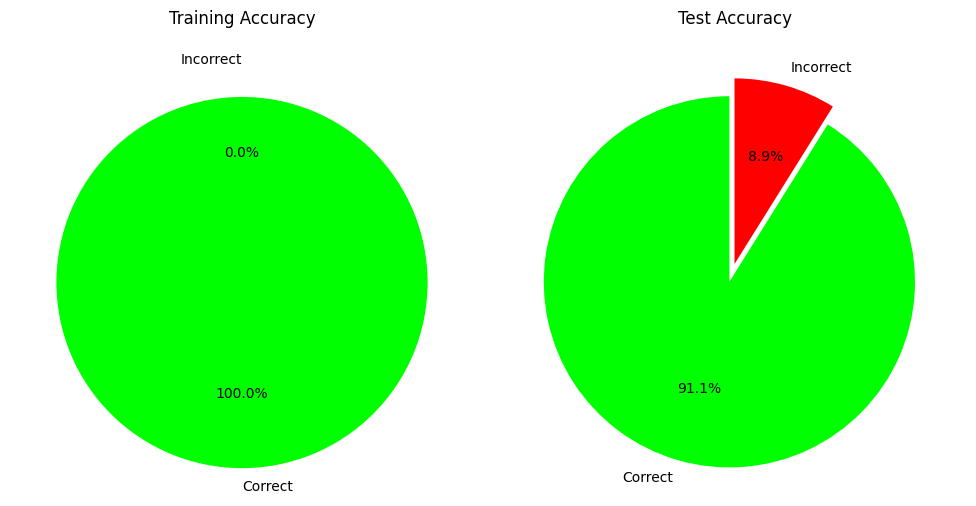

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = ["#00FF00", "#FF0000"]  # Green for correct, red for incorrect
ax1.pie(
    [train_acc, 1 - train_acc],
    labels=["Correct", "Incorrect"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0.1, 0),
)
ax1.set_title("Training Accuracy")
ax2.pie(
    [test_acc, 1 - test_acc],
    labels=["Correct", "Incorrect"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0.1, 0),
)
ax2.set_title("Test Accuracy")
plt.tight_layout()
plt.show()

### Model Confusion Matrix

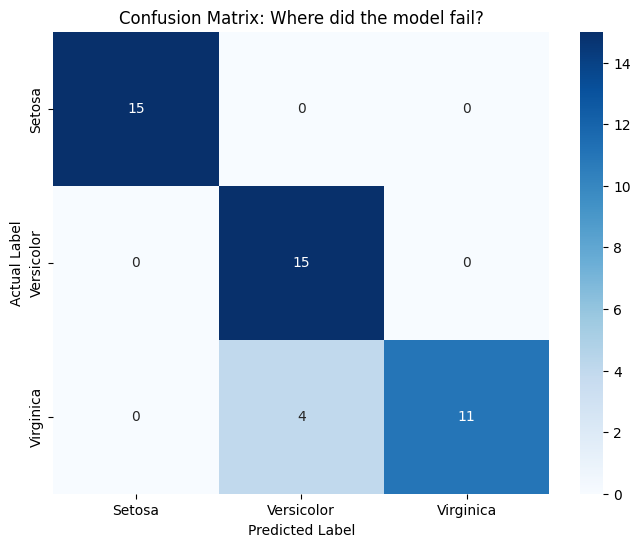

In [87]:
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get raw scores
        outputs = model(X_batch)
        # Convert raw scores to class index (0, 1, or 2)
        _, predicted = torch.max(outputs, 1)
        # Store results
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Setosa", "Versicolor", "Virginica"],
    yticklabels=["Setosa", "Versicolor", "Virginica"],
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix: Where did the model fail?")
plt.show()

### Model Training vs Validation Over Epochs

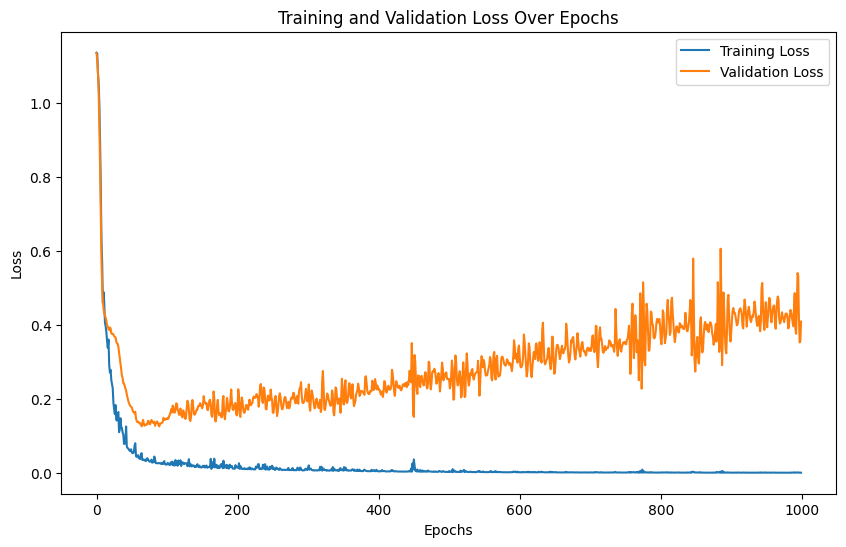

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

### Model Classification Report

In [89]:
print(
    classification_report(
        y_true, y_pred, target_names=["Setosa", "Versicolor", "Virginica"]
    )
)

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.79      1.00      0.88        15
   Virginica       1.00      0.73      0.85        15

    accuracy                           0.91        45
   macro avg       0.93      0.91      0.91        45
weighted avg       0.93      0.91      0.91        45



### ROC Curve

In [90]:
y_probs = []
y_true = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get Logits (Raw scores)
        logits = model(X_batch)
        # Apply Softmax to get Probabilities (0.0 to 1.0)
        probs = F.softmax(logits, dim=1)
        # Store results
        y_probs.extend(probs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
# Convert to numpy array for Scikit-Learn
y_probs = np.array(y_probs)
y_probs

array([[4.00236502e-07, 9.23978775e-13, 9.99999642e-01],
       [2.40762715e-10, 1.00000000e+00, 1.50147212e-12],
       [5.48361498e-08, 9.99999881e-01, 3.61525174e-08],
       [2.02431183e-09, 1.00000000e+00, 3.18816293e-11],
       [1.69060449e-03, 2.99355835e-01, 6.98953509e-01],
       [6.71739713e-08, 2.85304623e-19, 9.99999881e-01],
       [8.65986449e-11, 1.00000000e+00, 4.84566272e-13],
       [1.43261696e-11, 1.00000000e+00, 1.24462030e-14],
       [9.99951601e-01, 4.64147306e-05, 1.99366923e-06],
       [9.49466198e-07, 1.72834932e-13, 9.99999046e-01],
       [9.99944806e-01, 5.50656841e-05, 1.50928585e-07],
       [9.99991536e-01, 2.58665114e-06, 5.78872823e-06],
       [4.55345344e-07, 1.01208592e-12, 9.99999523e-01],
       [9.40001264e-05, 3.79033554e-05, 9.99868035e-01],
       [9.99977827e-01, 2.09149839e-05, 1.28188844e-06],
       [9.23006974e-06, 2.72550840e-12, 9.99990821e-01],
       [6.61744270e-12, 1.00000000e+00, 7.42702840e-17],
       [9.99982357e-01, 1.69110

In [91]:
final_auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
final_auc_score

0.9874074074074075

Overall ROC AUC Score: 0.9874


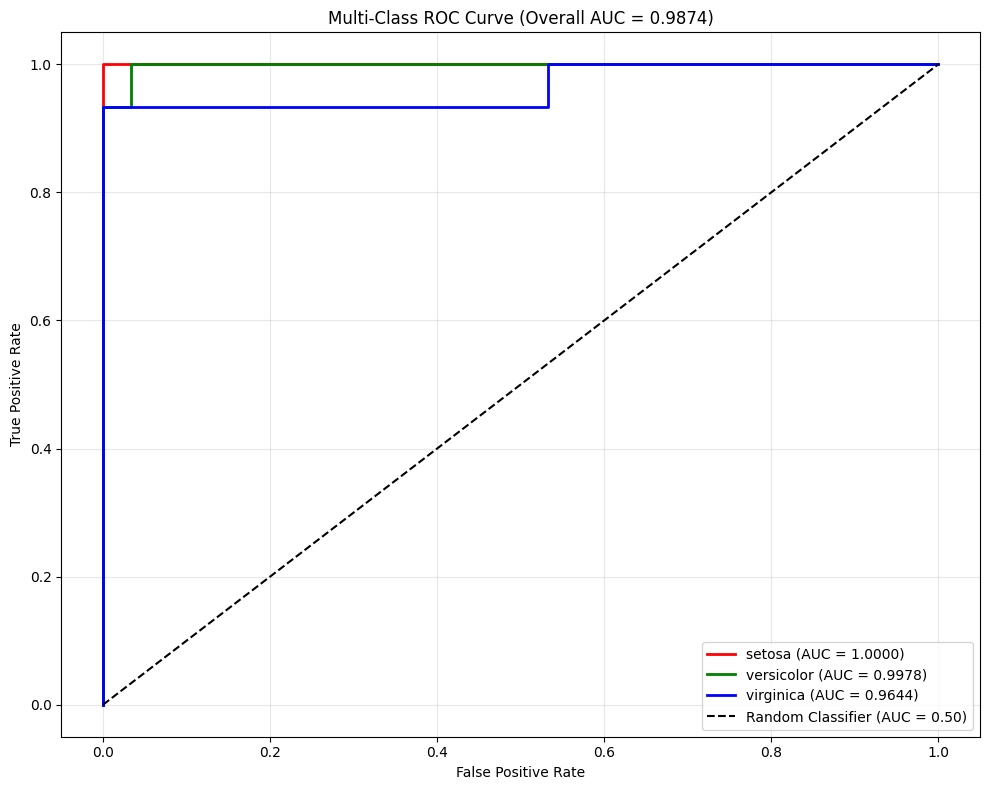

In [92]:
final_auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
print(f"Overall ROC AUC Score: {final_auc_score:.4f}")
colors = ["red", "green", "blue"]
plt.figure(figsize=(10, 8))
for class_label in range(len(TARGET_VARS)):
    # Create binary target for this specific class (One-vs-Rest)
    y_true_binary = (np.array(y_true) == class_label).astype(int)
    # Get the curve points
    fpr, tpr, _ = roc_curve(y_true_binary, y_probs[:, class_label])
    # Calculate AUC for this specific class
    current_auc = auc(fpr, tpr)
    # Plot
    plt.plot(
        fpr,
        tpr,
        color=colors[class_label],
        lw=2,
        label=f"{TARGET_VARS[class_label]} (AUC = {current_auc:.4f})",
    )
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-Class ROC Curve (Overall AUC = {final_auc_score:.4f})")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Summary Metrics

In [93]:
test_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted"
)
auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
print("-" * 101)
print(f"{'METRIC':<18} {'SCORE':<10} {'DESCRIPTION'}")
print("-" * 101)
print(
    f"{'Accuracy':<18} {test_accuracy:.4f}     Overall correctness (caution: misleading if classes are imbalanced)"
)
print(
    f"{'Precision':<18} {precision:.4f}     Trustworthiness: When it predicts 'Yes', how often is it right?"
)
print(
    f"{'Recall':<18} {recall:.4f}     Coverage: Of all actual 'Yes' cases, how many did we find?"
)
print(
    f"{'F1-Score':<18} {f1:.4f}     Balance: Harmonic mean of Precision & Recall (good for unequal classes)"
)
print(
    f"{'ROC AUC':<18} {auc_score:.4f}     Separability: How well it distinguishes between classes (1.0 = perfect)"
)
print("-" * 101)

-----------------------------------------------------------------------------------------------------
METRIC             SCORE      DESCRIPTION
-----------------------------------------------------------------------------------------------------
Accuracy           0.9111     Overall correctness (caution: misleading if classes are imbalanced)
Precision          0.9298     Trustworthiness: When it predicts 'Yes', how often is it right?
Recall             0.9111     Coverage: Of all actual 'Yes' cases, how many did we find?
F1-Score           0.9095     Balance: Harmonic mean of Precision & Recall (good for unequal classes)
ROC AUC            0.9874     Separability: How well it distinguishes between classes (1.0 = perfect)
-----------------------------------------------------------------------------------------------------


## Postprocessing

### SHAP

#### Create SHAP Explainer & Compute Values

In [94]:
def model_predict(data_numpy):
    """
    Wrapper function to make a PyTorch model compatible with SHAP Explainer.

    Parameters:
        data_numpy (np.ndarray): A 2D Numpy array of input features
                                 with shape (n_samples, n_features).

    Returns:
        np.ndarray: A 2D Numpy array of class probabilities with shape
                    (n_samples, n_classes). Each row sums to 1.0.
    """
    data_tensor = torch.tensor(data_numpy).float().to(DEVICE)
    model.eval()
    with torch.no_grad():
        logits = model(data_tensor)
        probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()


# We summarize the training background to 100 representative samples (speeds up calculation)
background = shap.kmeans(X_train_scaled.values, 100)
explainer = shap.KernelExplainer(model_predict, background)

# Note: For multi-class, this returns a LIST of n arrays (one per class)
shap_values_all = explainer.shap_values(X_test_scaled.values)

  0%|          | 0/45 [00:00<?, ?it/s]

#### Global Explanation (Feature Importance)

/var/folders/qg/60m3b34x32gczgr10l3665300000gn/T/ipykernel_99664/2628907736.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


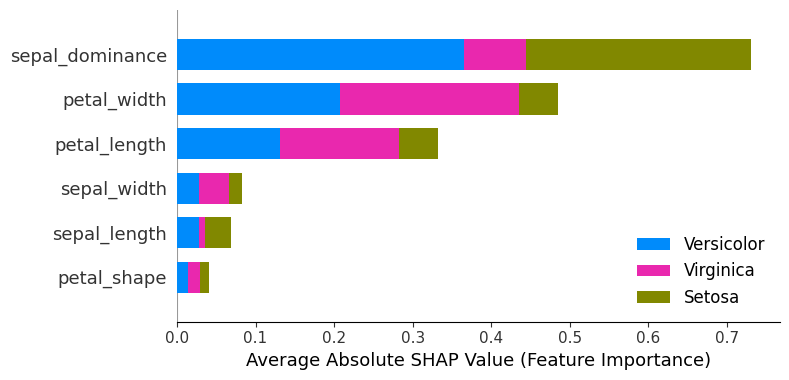

In [95]:
plt.figure(figsize=(10, 5))
shap.summary_plot(
    shap_values_all,
    X_test_scaled,
    class_names=["Setosa", "Versicolor", "Virginica"],
    plot_type="bar",
    show=False,
)
plt.xlabel("Average Absolute SHAP Value (Feature Importance)")
plt.tight_layout()
plt.show()

## New Model

In [96]:
IN_FEATURES = 3
IN_FEATURES

3

### Re-Create `Features` Variable for Audit & Modeling 

In [97]:
lean_features = ["sepal_dominance", "petal_width", "petal_length"]
lean_features

['sepal_dominance', 'petal_width', 'petal_length']

In [98]:
class NewModel(nn.Module):
    """
    A feedforward neural network with two hidden layers and optional dropout.
    """

    def __init__(
        self,
        in_features=IN_FEATURES,
        h1=H1,
        h2=H2,
        out_features=OUT_FEATURES,
        dropout=DROPOUT,
    ):
        """
        Initializes the neural network layers.

        Parameters:
            in_features (int): Number of input features.
            h1 (int): Number of neurons in the first hidden layer.
            h2 (int): Number of neurons in the second hidden layer.
            out_features (int): Number of output features.
            dropout (float): Dropout rate (0.0 = no dropout).

        Returns:
            None
        """
        super(NewModel, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

### Re-Instantiate Model

In [99]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
new_model = NewModel().to(DEVICE)
new_model

NewModel(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [100]:
next(new_model.parameters()).device

device(type='mps', index=0)

### Re-Train-Test Split Model

In [101]:
X = df_preprocessed[lean_features].values.astype("float32")
X

array([[1. , 0.2, 1.4],
       [1. , 0.2, 1.4],
       [1. , 0.2, 1.3],
       [1. , 0.2, 1.5],
       [1. , 0.2, 1.4],
       [1. , 0.4, 1.7],
       [1. , 0.3, 1.4],
       [1. , 0.2, 1.5],
       [1. , 0.2, 1.4],
       [1. , 0.1, 1.5],
       [1. , 0.2, 1.5],
       [1. , 0.2, 1.6],
       [1. , 0.1, 1.4],
       [1. , 0.1, 1.1],
       [1. , 0.2, 1.2],
       [1. , 0.4, 1.5],
       [1. , 0.4, 1.3],
       [1. , 0.3, 1.4],
       [1. , 0.3, 1.7],
       [1. , 0.3, 1.5],
       [1. , 0.2, 1.7],
       [1. , 0.4, 1.5],
       [1. , 0.2, 1. ],
       [1. , 0.5, 1.7],
       [1. , 0.2, 1.9],
       [1. , 0.2, 1.6],
       [1. , 0.4, 1.6],
       [1. , 0.2, 1.5],
       [1. , 0.2, 1.4],
       [1. , 0.2, 1.6],
       [1. , 0.2, 1.6],
       [1. , 0.4, 1.5],
       [1. , 0.1, 1.5],
       [1. , 0.2, 1.4],
       [1. , 0.1, 1.5],
       [1. , 0.2, 1.2],
       [1. , 0.2, 1.3],
       [1. , 0.1, 1.5],
       [1. , 0.2, 1.3],
       [1. , 0.2, 1.5],
       [1. , 0.3, 1.3],
       [1. , 0.3

In [102]:
y = df_preprocessed[TARGET_VAR].values.astype("int64")
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [103]:
X.shape

(150, 3)

In [104]:
y.shape

(150,)

In [105]:
train_idx, test_idx = train_test_split(
    np.arange(len(X)), test_size=TEST_SIZE, random_state=SEED, stratify=y
)
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
len(train_idx), len(test_idx)

(105, 45)

In [106]:
X_train

array([[0. , 1.1, 3. ],
       [0. , 1.5, 4.5],
       [1. , 0.3, 1.5],
       [0. , 2.3, 5.9],
       [0. , 1.3, 4.1],
       [0. , 2.3, 5.2],
       [1. , 0.1, 1.5],
       [1. , 0.2, 1.6],
       [1. , 0.2, 1.4],
       [0. , 2.1, 5.9],
       [0. , 2. , 5.1],
       [1. , 0.2, 1.4],
       [1. , 0.2, 1.6],
       [0. , 1.5, 4.5],
       [0. , 1.1, 3.8],
       [0. , 1.8, 6. ],
       [1. , 0.4, 1.6],
       [1. , 0.2, 1.6],
       [0. , 2.5, 5.7],
       [0. , 1.8, 4.8],
       [1. , 0.4, 1.5],
       [0. , 1.8, 4.9],
       [0. , 2.1, 6.6],
       [0. , 2. , 6.7],
       [0. , 1.2, 4.2],
       [1. , 0.3, 1.4],
       [1. , 0.4, 1.5],
       [1. , 0.4, 1.3],
       [0. , 1.5, 4.9],
       [0. , 1.3, 4. ],
       [1. , 0.4, 1.5],
       [1. , 0.3, 1.4],
       [0. , 1. , 4.1],
       [0. , 1.3, 3.6],
       [1. , 0.1, 1.4],
       [1. , 0.3, 1.4],
       [0. , 1.4, 4.4],
       [0. , 1.9, 5. ],
       [0. , 2. , 6.4],
       [1. , 0.2, 1.4],
       [0. , 2.1, 5.6],
       [1. , 0.2

In [107]:
X_train.shape

(105, 3)

In [108]:
y_train

array([1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 2, 1, 0, 2,
       2, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 2, 0, 2, 0, 2, 0,
       2, 1, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 1, 1, 2,
       2, 0, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2,
       2, 0, 1, 1, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0])

In [109]:
y_train.shape

(105,)

In [110]:
X_test

array([[0. , 1.8, 6.3],
       [0. , 1.4, 4.7],
       [0. , 1.5, 5.1],
       [0. , 1.6, 4.7],
       [0. , 1.8, 4.9],
       [0. , 2.4, 5.6],
       [0. , 1.3, 4. ],
       [0. , 1.1, 3.9],
       [1. , 0.2, 1.7],
       [0. , 2.3, 5.1],
       [1. , 0.2, 1.2],
       [1. , 0.2, 1.3],
       [0. , 1.8, 5.8],
       [0. , 1.8, 5.5],
       [1. , 0.2, 1.4],
       [0. , 2.3, 5.4],
       [0. , 1. , 3.3],
       [1. , 0.2, 1.5],
       [1. , 0.5, 1.7],
       [1. , 0.3, 1.7],
       [0. , 1.3, 4.3],
       [1. , 0.2, 1.5],
       [0. , 1.4, 4.4],
       [0. , 2.2, 5.8],
       [0. , 1.8, 4.8],
       [0. , 1.5, 4.5],
       [0. , 1.5, 4.5],
       [0. , 1. , 3.3],
       [0. , 1.5, 4.5],
       [1. , 0.2, 1.2],
       [0. , 1.4, 5.6],
       [0. , 2.2, 5.6],
       [0. , 1.6, 4.5],
       [1. , 0.2, 1.4],
       [0. , 1.9, 5.3],
       [1. , 0.3, 1.3],
       [1. , 0.2, 1.3],
       [1. , 0.2, 1.3],
       [1. , 0.6, 1.6],
       [0. , 1.7, 5. ],
       [0. , 1.3, 4.5],
       [1. , 0.2

In [111]:
X_test.shape

(45, 3)

In [112]:
y_test

array([2, 1, 2, 1, 2, 2, 1, 1, 0, 2, 0, 0, 2, 2, 0, 2, 1, 0, 0, 0, 1, 0,
       1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1, 1, 0, 2, 2,
       1])

In [113]:
y_test.shape

(45,)

### Re-Scale Features

In [114]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=lean_features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=lean_features)
# Re-save scaler for inference
joblib.dump(scaler, "iris_scaler.pkl")
print("Scaler Saved: 'iris_scaler.pkl'")

Scaler Saved: 'iris_scaler.pkl'


### Re-Create Custom Dataset (Memory Efficient)

In [115]:
class NumpyDataset(torch.utils.data.Dataset):
    """
    A memory-efficient dataset that keeps data as numpy arrays.
    Converts to tensors only when batching (on-demand).
    Specifically designed for classification tasks.
    """

    def __init__(self, X, y, device):
        """
        Initializes the dataset with numpy arrays.

        Parameters:
            X (np.ndarray): Feature array.
            y (np.ndarray): Label array (classification targets).
            device (torch.device): Device to move tensors to.

        Returns:
            None
        """
        self.X = X
        self.y = y
        self.device = device

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Returns a single sample as tensors on the specified device.

        Parameters:
            idx (int): Index of the sample.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Feature and label tensors.
        """
        X_tensor = torch.tensor(self.X[idx]).float().to(self.device)
        y_tensor = torch.tensor(self.y[idx]).long().to(self.device)
        return X_tensor, y_tensor

## Re-Create DataLoaders

In [116]:
train_dataset = NumpyDataset(X_train_scaled.values, y_train, DEVICE)
test_dataset = NumpyDataset(X_test_scaled.values, y_test, DEVICE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_loader), len(test_loader)

(4, 2)

## Re-Create Loss Function & Optimizer

In [117]:
# Initialize the model strictly using CrossEntropyLoss for the classification task
if df[TARGET_VAR].nunique() == 2:
    # Binary Classification (Output layer must have 1 neuron)
    criterion = nn.BCEWithLogitsLoss()
else:
    # Multi-class Classification (Output layer must have 2+ neurons)
    criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

In [118]:
optimizer = torch.optim.AdamW(new_model.parameters(), lr=LR)
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.01
)

## Re-Train Model

In [119]:
train_losses = []
val_losses = []
train_losses, val_losses

([], [])

In [120]:
best_val_loss = float("inf")
for i in range(EPOCHS):
    new_model.train()
    epoch_train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = new_model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)
    new_model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_val_pred = new_model(X_batch)
            epoch_val_loss += criterion(y_val_pred, y_batch).item()
    val_loss = epoch_val_loss / len(test_loader)
    val_losses.append(val_loss)
    # Save model if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(new_model.state_dict(), "iris_model.pth")
    if i % LOG_INTERVAL == 0:
        print(
            f"Epoch {i}/{EPOCHS} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}"
        )
print("-" * 30)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("Model Weights Saved: 'iris_model.pth'")

Epoch 0/1000 - Training Loss: 1.0735 - Validation Loss: 1.0206
Epoch 10/1000 - Training Loss: 0.1752 - Validation Loss: 0.2261
Epoch 20/1000 - Training Loss: 0.0578 - Validation Loss: 0.1696
Epoch 30/1000 - Training Loss: 0.0763 - Validation Loss: 0.1637
Epoch 40/1000 - Training Loss: 0.0554 - Validation Loss: 0.1845
Epoch 50/1000 - Training Loss: 0.0467 - Validation Loss: 0.1695
Epoch 60/1000 - Training Loss: 0.0604 - Validation Loss: 0.2041
Epoch 70/1000 - Training Loss: 0.0714 - Validation Loss: 0.1780
Epoch 80/1000 - Training Loss: 0.0942 - Validation Loss: 0.1906
Epoch 90/1000 - Training Loss: 0.0404 - Validation Loss: 0.1591
Epoch 100/1000 - Training Loss: 0.0532 - Validation Loss: 0.1836
Epoch 110/1000 - Training Loss: 0.0411 - Validation Loss: 0.1731
Epoch 120/1000 - Training Loss: 0.0388 - Validation Loss: 0.1757
Epoch 130/1000 - Training Loss: 0.0389 - Validation Loss: 0.1697
Epoch 140/1000 - Training Loss: 0.0539 - Validation Loss: 0.1631
Epoch 150/1000 - Training Loss: 0.06

## Evaluate Model

In [121]:
new_model.eval()

NewModel(
  (fc1): Linear(in_features=3, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [122]:
total_val_loss = 0.0
total_val_loss

0.0

In [123]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_eval = new_model(X_batch)
        total_val_loss += criterion(y_eval, y_batch).item()
val_loss = total_val_loss / len(test_loader)
val_loss

0.18089495413005352

### Model Accuracy & Loss

In [124]:
# Evaluate the trained model using standard classification accuracy
new_model.eval()
train_correct = 0
train_total = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for X_batch, y_batch in train_loader:
        preds = new_model(X_batch).argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += len(y_batch)
    for X_batch, y_batch in test_loader:
        preds = new_model(X_batch).argmax(dim=1)
        test_correct += (preds == y_batch).sum().item()
        test_total += len(y_batch)
train_acc = train_correct / train_total
test_acc = test_correct / test_total
print(f"Train Accuracy: {train_acc:.4f} ({train_correct}/{train_total})")
print(f"Test Accuracy: {test_acc:.4f} ({test_correct}/{test_total})")
print(f"Training Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Accuracy: 0.9714 (102/105)
Test Accuracy: 0.9333 (42/45)
Training Loss: 0.0425
Validation Loss: 0.1809


### Model Correct vs Incorrect Predictions

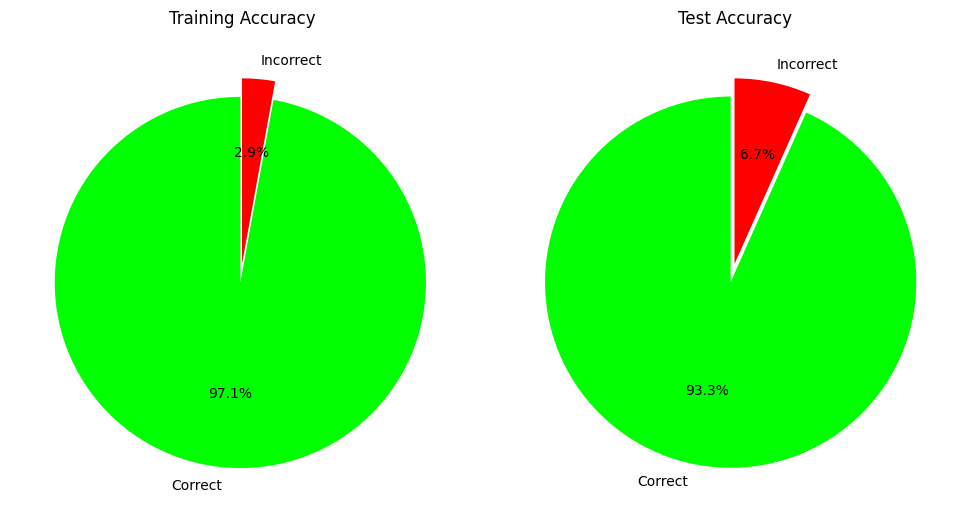

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
colors = ["#00FF00", "#FF0000"]  # Green for correct, red for incorrect
ax1.pie(
    [train_acc, 1 - train_acc],
    labels=["Correct", "Incorrect"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0.1, 0),
)
ax1.set_title("Training Accuracy")
ax2.pie(
    [test_acc, 1 - test_acc],
    labels=["Correct", "Incorrect"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    explode=(0.1, 0),
)
ax2.set_title("Test Accuracy")
plt.tight_layout()
plt.show()

### Model Confusion Matrix

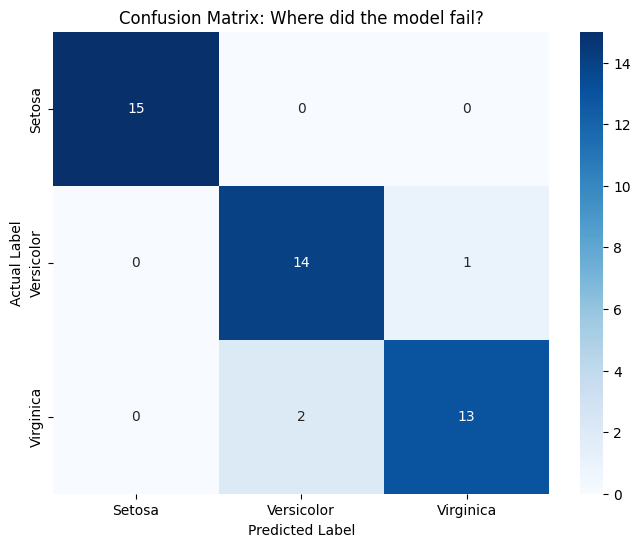

In [126]:
y_true = []
y_pred = []
new_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get raw scores
        outputs = new_model(X_batch)
        # Convert raw scores to class index (0, 1, or 2)
        _, predicted = torch.max(outputs, 1)
        # Store results
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Setosa", "Versicolor", "Virginica"],
    yticklabels=["Setosa", "Versicolor", "Virginica"],
)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix: Where did the model fail?")
plt.show()

### Model Training vs Validation Over Epochs

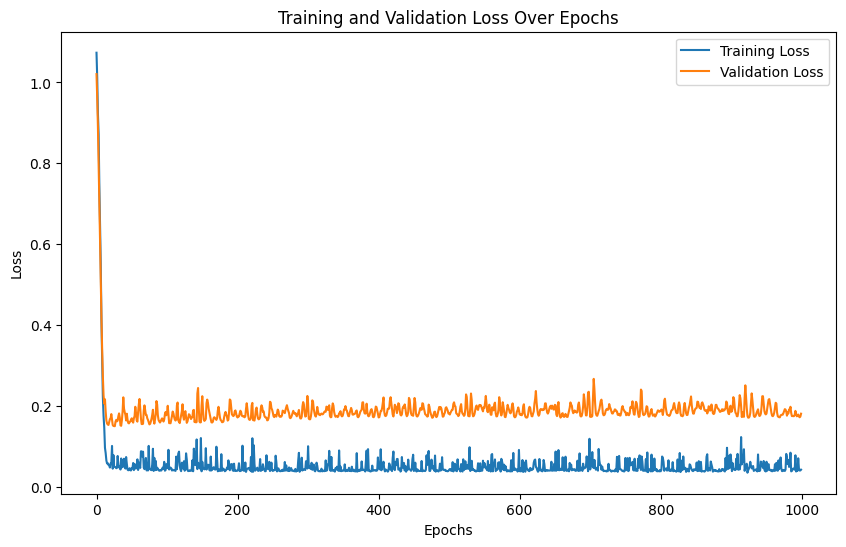

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

### Model Classification Report

In [128]:
print(
    classification_report(
        y_true, y_pred, target_names=["Setosa", "Versicolor", "Virginica"]
    )
)

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        15
  Versicolor       0.88      0.93      0.90        15
   Virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45



### ROC Curve

In [129]:
y_probs = []
y_true = []
new_model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        # Get Logits (Raw scores)
        logits = new_model(X_batch)
        # Apply Softmax to get Probabilities (0.0 to 1.0)
        probs = F.softmax(logits, dim=1)
        # Store results
        y_probs.extend(probs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())
# Convert to numpy array for Scikit-Learn
y_probs = np.array(y_probs)
y_probs

array([[2.10318512e-06, 6.44016080e-04, 9.99353826e-01],
       [1.25439241e-04, 9.88427341e-01, 1.14471633e-02],
       [4.94585256e-04, 6.37881696e-01, 3.61623734e-01],
       [3.18270089e-04, 9.02363241e-01, 9.73184407e-02],
       [3.73496441e-04, 1.99031666e-01, 8.00594926e-01],
       [5.84482279e-07, 3.01060441e-04, 9.99698400e-01],
       [1.36753415e-05, 9.99596417e-01, 3.89885303e-04],
       [7.66666199e-06, 9.99794066e-01, 1.98312351e-04],
       [9.99996662e-01, 2.90368075e-06, 5.10239431e-07],
       [8.49259504e-06, 1.47497375e-03, 9.98516619e-01],
       [9.99998927e-01, 8.95015148e-07, 1.33037830e-07],
       [9.99998689e-01, 1.13254055e-06, 1.74074216e-07],
       [1.54832778e-05, 2.10663257e-03, 9.97877955e-01],
       [5.12242877e-05, 4.28376347e-03, 9.95665014e-01],
       [9.99998331e-01, 1.43310467e-06, 2.27769149e-07],
       [2.56325688e-06, 7.24289392e-04, 9.99273121e-01],
       [3.61280377e-06, 9.99936581e-01, 5.97863072e-05],
       [9.99997854e-01, 1.81343

In [130]:
final_auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
final_auc_score

0.994074074074074

Overall ROC AUC Score: 0.9941


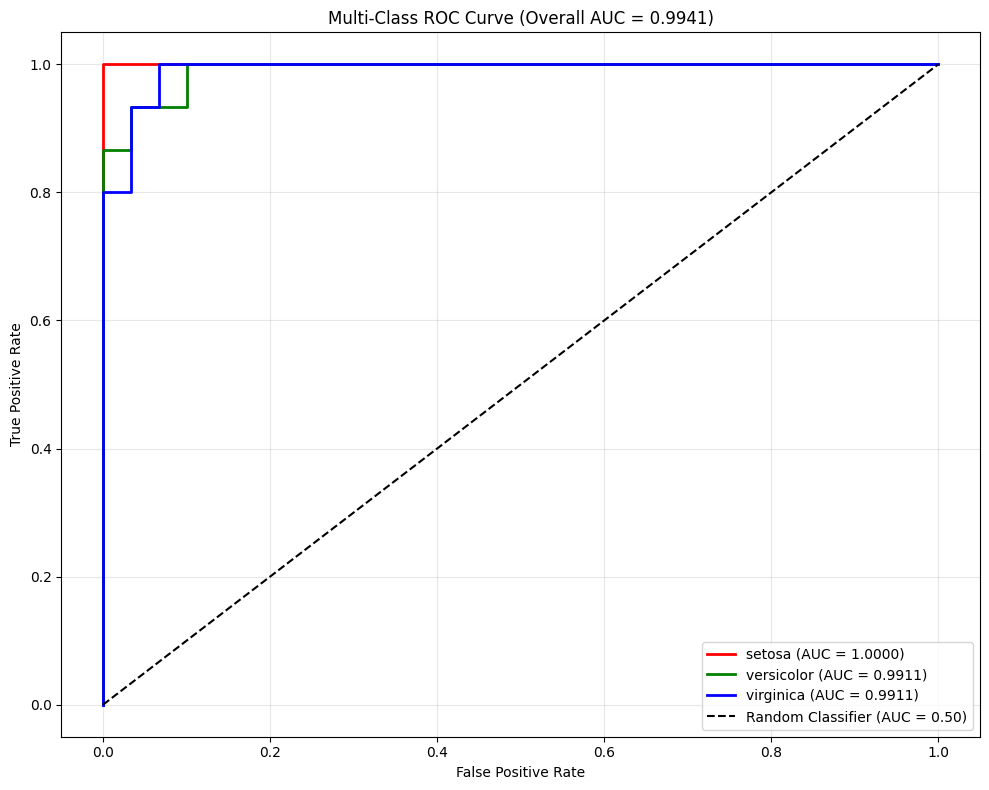

In [131]:
final_auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
print(f"Overall ROC AUC Score: {final_auc_score:.4f}")
colors = ["red", "green", "blue"]
plt.figure(figsize=(10, 8))
for class_label in range(len(TARGET_VARS)):
    # Create binary target for this specific class (One-vs-Rest)
    y_true_binary = (np.array(y_true) == class_label).astype(int)
    # Get the curve points
    fpr, tpr, _ = roc_curve(y_true_binary, y_probs[:, class_label])
    # Calculate AUC for this specific class
    current_auc = auc(fpr, tpr)
    # Plot
    plt.plot(
        fpr,
        tpr,
        color=colors[class_label],
        lw=2,
        label=f"{TARGET_VARS[class_label]} (AUC = {current_auc:.4f})",
    )
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"Multi-Class ROC Curve (Overall AUC = {final_auc_score:.4f})")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Summary Metrics

In [132]:
test_accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted"
)
auc_score = roc_auc_score(y_true, y_probs, multi_class="ovr")
print("-" * 101)
print(f"{'METRIC':<18} {'SCORE':<10} {'DESCRIPTION'}")
print("-" * 101)
print(
    f"{'Accuracy':<18} {test_accuracy:.4f}     Overall correctness (caution: misleading if classes are imbalanced)"
)
print(
    f"{'Precision':<18} {precision:.4f}     Trustworthiness: When it predicts 'Yes', how often is it right?"
)
print(
    f"{'Recall':<18} {recall:.4f}     Coverage: Of all actual 'Yes' cases, how many did we find?"
)
print(
    f"{'F1-Score':<18} {f1:.4f}     Balance: Harmonic mean of Precision & Recall (good for unequal classes)"
)
print(
    f"{'ROC AUC':<18} {auc_score:.4f}     Separability: How well it distinguishes between classes (1.0 = perfect)"
)
print("-" * 101)

-----------------------------------------------------------------------------------------------------
METRIC             SCORE      DESCRIPTION
-----------------------------------------------------------------------------------------------------
Accuracy           0.9333     Overall correctness (caution: misleading if classes are imbalanced)
Precision          0.9345     Trustworthiness: When it predicts 'Yes', how often is it right?
Recall             0.9333     Coverage: Of all actual 'Yes' cases, how many did we find?
F1-Score           0.9333     Balance: Harmonic mean of Precision & Recall (good for unequal classes)
ROC AUC            0.9941     Separability: How well it distinguishes between classes (1.0 = perfect)
-----------------------------------------------------------------------------------------------------


## Load Model

In [133]:
loaded_model = NewModel().to(DEVICE)
loaded_model.load_state_dict(
    torch.load("iris_model.pth", map_location=DEVICE, weights_only=True)
)
loaded_model.eval()
print("Model Loaded: 'iris_model.pth'")

Model Loaded: 'iris_model.pth'


## Load Scaler

In [134]:
scaler = joblib.load("iris_scaler.pkl")
print("Scaler Loaded: 'iris_scaler.pkl'")

Scaler Loaded: 'iris_scaler.pkl'


## Inference

In [135]:
def _prepare_input_tensor(features, device):
    """
    Prepares input features as a tensor on the specified device.

    Parameters:
        features (list[float]): List of feature values.
        device (torch.device): Device to move tensor to.

    Returns:
        torch.Tensor: Prepared input tensor with shape (1, n_features).
    """
    X_new = torch.tensor(features).float().to(device)
    if X_new.dim() == 1:
        X_new = X_new.unsqueeze(0)
    return X_new


def _get_prediction_details(logits):
    """
    Extracts predicted class index and confidence from model logits.

    Parameters:
        logits (torch.Tensor): Raw model output logits.

    Returns:
        tuple[int, float]: (predicted_class_index, confidence_score).
    """
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = logits.argmax(dim=1).item()
    confidence = probabilities[0][predicted_class].item()
    return predicted_class, confidence


def predict(model, features):
    """
    Make a prediction on new data for classification.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        features (list[float]): List of feature values.

    Returns:
        tuple[str, float]: (class_name, confidence) for classification.
    """
    species_map = {0: "setosa", 1: "versicolor", 2: "virginica"}
    model.eval()
    with torch.no_grad():
        X_new = _prepare_input_tensor(features, DEVICE)
        logits = model(X_new)
        pred_class, confidence = _get_prediction_details(logits)
        return species_map[pred_class], confidence

### Example: New Flower Measurements 

In [136]:
# 1. Define Raw Data (matching lean_features order: sepal_dominance, petal_width, petal_length)
sepal_dominance = 1.0  # setosa IS sepal_dominant (sepal_length > 2*petal_length)
petal_width = 0.2  # small petal width → setosa characteristic
petal_length = 1.4  # small petal length → setosa characteristic
raw_flower = [sepal_dominance, petal_width, petal_length]

# 2. CRITICAL: Scale using the fitted scaler from training
scaled_flower = scaler.transform([raw_flower])

# 3. Predict using SCALED data (classification only)
species, confidence = predict(loaded_model, scaled_flower[0])

print(f"Raw Input:         {raw_flower}")
# print(f"Scaled Input:      {list(scaled_flower[0])}")
print(f"Predicted Species: {species}")
print(f"Confidence:        {confidence:.2%}")

Raw Input:         [1.0, 0.2, 1.4]
Predicted Species: setosa
Confidence:        99.96%
